<div class="usecase-title"><h2><b>Urban Biodiversity Atlas &amp; Habitat Connectivity</b></h2></div>

<div class="usecase-authors"><b>Authored by: </b> Vamshi Krishna Y R</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Pandas, Matplotlib, Folium, Geopandas, Plotly, Scikit-learn</div>
</div>

<div class="usecase-section-header"><h3><b>Use case scenario</b></h3></div>

**As a:** City of Melbourne urban planner, environmental advocate, or community member interested in enhancing urban biodiversity and ecological connectivity.<br>

**I want to:** Identify biodiversity cold-spots, map habitat gaps, and recommend targeted planting or habitat interventions to reconnect fragmented green spaces.<br>

**So that I can:** Support evidence-based greening initiatives, foster community stewardship, and improve the ecological health and liveability of Melbourne’s urban environment.<br>

**By:**
- Integrating open datasets on trees, canopy cover, invertebrates, open spaces, and barriers.
- Computing insect biodiversity metrics and identifying ecological hot-spots and cold-spots.
- Modelling habitat connectivity and recommending priority actions for planting or habitat structures.
- Publishing actionable insights through interactive dashboards and open APIs.

<div class="usecase-section-header"><h3><b>What this use case will teach you</b></h3></div>

- How to ingest, clean, and spatially analyse diverse urban ecological datasets using Python and geospatial libraries.
- Techniques for quantifying species richness, diversity, and identifying ecological clusters in an urban context.
- Approaches to model habitat connectivity and prioritise interventions using spatial analysis and predictive modelling.
- Best practices for communicating actionable insights through interactive dashboards and open data APIs.
- The societal and environmental impact of data-driven urban greening strategies.

<div class="usecase-section-header"><h3><b>Objectives</b></h3></div>

- Map current biodiversity and diagnose habitat gaps across the City of Melbourne.
- Prioritise micro-locations for targeted planting or habitat structures to enhance species connectivity.
- Develop and publish an interactive Urban Biodiversity Atlas dashboard and open API.
- Empower council and community stakeholders with actionable, evidence-based recommendations for urban greening.

## Initialisation
Importing necessary libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# Enable inline plotting in Jupyter notebooks
try:
    from IPython import get_ipython
    get_ipython().run_line_magic('matplotlib', 'inline')
except Exception:
    pass

# Data handling
import pandas as pd                   # Data manipulation (e.g. reading CSVs, merging sensor & API data)
import numpy as np                    # Numerical operations (e.g. statistics, array maths)
from numpy import nan                  # Not-a-Number (NaN) value for missing data
import math                           # Maths functions (e.g. sqrt for computing buffer radii)
import json                           # Parse JSON responses from Open Meteo or other APIs
import json as _json                  # Parse JSON responses from Open Meteo or other APIs
from io import StringIO               # In-memory text I/O (e.g. loading CSV data from a string)
import re                            # Regular expressions for text processing (e.g. extracting genus from notes)
import os                             # File system operations (e.g. create output directories)

# Geospatial processing
import geopandas as gpd               # GeoDataFrames for shapefiles & GeoJSON
from shapely.geometry import Point, shape, Polygon  # Create/manipulate geometric objects (sensor points, canopy polygons)
from shapely.geometry import shape as _shape  # Alias for shape
from shapely.ops import unary_union     # Merge multiple geometries (e.g. dissolve canopy polygons)
from geopy.distance import geodesic   # Calculate great-circle distances (e.g. Haversine formula for 50 m radius)
from geopy.geocoders import Nominatim           # Geocoding (e.g. convert addresses to coordinates)
from geopy.extra.rate_limiter import RateLimiter # Geocoding rate limiter (e.g. avoid exceeding API limits)

# Static & interactive mapping
import contextily as ctx              # Basemap tiles for GeoPandas plots (e.g. OSM background)
import folium                         # Interactive leaflet maps in Jupyter (e.g. pan/zoom sensor coverage)
from folium.plugins import MarkerCluster  # Interactive map with Marker
from branca.element import Template, MacroElement # Overlay Legend on Folium Maps
import esda, libpysal               # Spatial statistics (e.g. Moran's I for spatial autocorrelation)
from esda import getisord           # Getis-Ord Gi* statistic

# Visualisation
import matplotlib.pyplot as plt       # Static charts (e.g. bar plots, heatmaps)
from matplotlib.lines import Line2D   # Custom legend elements
import seaborn as sns                 # Statistical viz (e.g. correlation matrix heatmap)
import plotly.express as px           # Interactive plots (e.g. time-series of PM₂.₅)

# HTTP requests with caching & retries
import requests                       # API calls (e.g. fetch tree-canopy GeoJSON)
import requests_cache                 # Cache API responses (avoid repeated rate limits)
from retry_requests import retry      # Retry logic (e.g. for transient network errors)
import openmeteo_requests             # Client for Open Meteo weather & air-pollution API

# Notebook display helpers
from IPython.display import IFrame    # Embed HTML (e.g. folium maps) directly in cells

# Utility data structures
from collections import defaultdict   # Default dictionaries (e.g. grouping counts by schedule)



#### Importing the data through API from open data portal of Melbourne

The below function accesses open datasets via API endpoints, enabling users to obtain information in CSV format suitable for in-depth analysis. By providing the dataset identifier and a valid API key, it issues a request to the Melbourne data portal and interprets the response to retrieve pertinent data. This method streamlines the incorporation of diverse datasets—such as microclimate sensor, urban tree canopies, and tree planting zone, facilitating straightforward access and efficient data integration for applications in urban planning research.

In [2]:
def import_data(datasetname): # pass in dataset name and api key

    """
    Imports a dataset from the City of Melbourne Open Data API.

    Parameters:
    - dataset_id (str): The unique dataset identifier.
    Returns:
    - pd.DataFrame: The imported dataset as a pandas DataFrame.
    """

    dataset_id = datasetname

    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    apikey = '<insert your API key>'
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC'
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        datasetname = pd.read_csv(StringIO(url_content), delimiter=';')
        print(f' Imported the {dataset_id} dataset with {len(datasetname)} records succesfully \n')
        return datasetname 
    else:
        return (print(f'Request failed with status code {response.status_code}'))


### Datasets

Melbourne’s liveability depends not only on its built form but also on the ecological health of its parks, streets and private gardens. Insects, birds and bats pollinate plants, recycle nutrients and form the base of urban food-webs, yet their habitat is fragmented by roads and dense development. In line with Chameleon’s mission to “enhance life through the application of smart-city technologies” and the  goal of showcasing practical applications of City-of-Melbourne (CoM) open data, this use case will build an Urban Biodiversity Atlas that quantifies species richness, pin-points ecological “cold-spots” and recommends green corridors that reconnect them. Insights will guide both council planting programmes and community-led actions such as pollinator gardens and nesting-box installations. 

Below are the primary datasets used


| Theme             | Dataset                                                                           | Source                                       | Key fields / notes                         |
| ----------------- | --------------------------------------------------------------------------------- | -------------------------------------------- | ------------------------------------------ |
| Flora structure   | **Trees with Species & Dimensions (Urban Forest)** – \~70 000 street & park trees | Melbourne open data ([link][1]) | Species, DBH, life-stage, health, location |
| Canopy extent     | **Tree Canopies 2021 (Urban Forest)**                                             | Melbourne open data ([link][2])                              | High-resolution canopy polygons            |
| Invertebrates     | **Insect Records – “Little Things that Run the City”**                            | Melbourne open data ([link][3])                           | Insect species, abundance, sampling site   |
| Suburbs         | **Small Areas for Census of Land Use**                                                      | Melbourne open data ([link][4])                                 | Suburb aggregation analysis |

[1]: https://data.melbourne.vic.gov.au/explore/dataset/trees-with-species-and-dimensions-urban-forest/information/ "Trees, with species and dimensions (Urban Forest)"
[2]: https://data.melbourne.vic.gov.au/explore/dataset/tree-canopies-2021-urban-forest/information/ "Tree Canopies 2021 (Urban Forest)"
[3]: https://data.melbourne.vic.gov.au/explore/dataset/insect-records-in-the-city-of-melbourne-from-little-things-that-run-the-city/information/ "Insect Records in the City of Melbourne (from Little Things that Run ..."
[4]: https://data.melbourne.vic.gov.au/explore/dataset/small-areas-for-census-of-land-use-and-employment-clue/information/ "Small Areas for Census of Land Use"

#### Importing dataset - insect-records-in-the-city-of-melbourne-from-little-things-that-run-the-city

**About the dataset**: This dataset contains detailed insect records from "The Little Things that Run the City" project - a critical resource for understanding urban biodiversity patterns across Melbourne. The collection includes identified insect species found across various parks and gardens, providing baseline data for mapping biodiversity hotspots and analysing habitat connectivity. Field surveys were conducted between October 2014 and March 2015, with species identification completed between April and September 2015. Understanding insect diversity is fundamental to developing targeted habitat interventions and measuring the ecological health of Melbourne's urban environment.

In [3]:
# Importing insect records dataset
insect_records = 'insect-records-in-the-city-of-melbourne-from-little-things-that-run-the-city' 
df_insect_records = import_data(insect_records)
df_insect_records.to_csv('df_insect_records.csv', index=False) # saving into a local file
df_insect_records_orig = df_insect_records #saving the original dataset
print('First few rows of the dataset:\n')
df_insect_records.head()


 Imported the insect-records-in-the-city-of-melbourne-from-little-things-that-run-the-city dataset with 1295 records succesfully 

First few rows of the dataset:



taxa   kingdom      phylum    class        order         family genus  \
0  Insect  ANIMALIA  ARTHROPODA  INSECTA  HYMENOPTERA   PTEROMALIDAE   NaN   
1  Insect  ANIMALIA  ARTHROPODA  INSECTA      DIPTERA     PYRGOTIDAE   NaN   
2  Insect  ANIMALIA  ARTHROPODA  INSECTA      DIPTERA   SCENOPINIDAE   NaN   
3  Insect  ANIMALIA  ARTHROPODA  INSECTA      DIPTERA       SEPSIDAE   NaN   
4  Insect  ANIMALIA  ARTHROPODA  INSECTA      DIPTERA  STRATIOMYIDAE   NaN   

  species identification_notes                  location  sighting_date  
0     NaN       Pteromalidae 4  Fitzroy-Treasury Gardens            NaN  
1     NaN         Pyrgotidae 1                Royal Park            NaN  
2     NaN       Scenopinidae 2                Royal Park            NaN  
3     NaN           Sepsidae 1              Princes Park            NaN  
4     NaN      Stratiomyidae 2            Lincoln Square            NaN

#### Importing dataset - tree-canopies-2021-urban-forest

**About the dataset:** The Tree Canopies 2021 - Urban Forest dataset maps the extent of tree canopy cover across the City of Melbourne using aerial imagery and LiDAR data. It provides detailed spatial insights into urban forest coverage, supporting initiatives in climate resilience, biodiversity, and urban planning.

In [4]:
# Importing tree canopy dataset
tree_canopy_2021 = 'tree-canopies-2021-urban-forest' 
df_tree_canopy_2021 = import_data(tree_canopy_2021)
df_tree_canopy_2021.to_csv('df_tree_canopy_2021.csv', index=False) # saving into a local file
df_tree_canopy_2021_orig = df_tree_canopy_2021 #saving the original dataset
print('First few rows of the dataset:\n')
df_tree_canopy_2021.head(5)


 Imported the tree-canopies-2021-urban-forest dataset with 57980 records succesfully 

First few rows of the dataset:

First few rows of the dataset:



geo_point_2d  \
0    -37.8298681237421, 144.98303001088595   
1  -37.829874533279096, 144.97144661356745   
2   -37.83021396760069, 144.98646678135142   
3   -37.828742240015515, 144.9011718210025   
4  -37.829920930428415, 144.96518349051888   

                                           geo_shape  
0  {"coordinates": [[[[144.9832974445821, -37.829...  
1  {"coordinates": [[[[144.9714529379414, -37.829...  
2  {"coordinates": [[[[144.98647926050035, -37.83...  
3  {"coordinates": [[[[144.90116683929529, -37.82...  
4  {"coordinates": [[[[144.96517363556384, -37.82...

#### Importing trees-with-species-and-dimensions-urban-forest

**About the dataset:** This dataset details the location, species and lifespan of Melbourne's urban forest by precinct. The City of Melbourne maintains more than 70,000 trees.

In [5]:
# Importing urban forest dataset
urban_forest = 'trees-with-species-and-dimensions-urban-forest' 
df_urban_forest = import_data(urban_forest)
df_urban_forest.to_csv('df_urban_forest.csv', index=False) # saving into a local file
df_urban_forest_orig = df_urban_forest #saving the original dataset
print('First few rows of the dataset:\n')
df_urban_forest.head(5)


 Imported the trees-with-species-and-dimensions-urban-forest dataset with 76928 records succesfully 

First few rows of the dataset:

First few rows of the dataset:



com_id      common_name             scientific_name          genus  \
0  1049657          Unknown     Melaleuca parvistaminea      Melaleuca   
1  1782373  Coastal Banksia        Banksia integrifolia        Banksia   
2  1604511          Red Box     Eucalyptus polyanthemos     Eucalyptus   
3  1070399         Ironbark      Eucalyptus sideroxylon     Eucalyptus   
4  1734680  Drooping sheoak  Allocasuarina verticillata  Allocasuarina   

          family  diameter_breast_height  year_planted date_planted  \
0      Myrtaceae                     NaN          1998   1998-12-17   
1     Proteaceae                     NaN          2020   2020-03-04   
2      Myrtaceae                     NaN          2015   2015-05-08   
3      Myrtaceae                    12.0          2006   2006-12-19   
4  Casuarinaceae                     NaN          2018   2018-09-05   

  age_description useful_life_expectency  useful_life_expectency_value  \
0             NaN                    NaN                           NaN   
1             NaN                    NaN                           NaN   
2             NaN                    NaN                           NaN   
3     Semi-Mature            31-60 years                          60.0   
4             NaN                    NaN                           NaN   

   precinct located_in  uploaddate                       coordinatelocation  \
0       NaN       Park  2021-01-10   -37.79070542406818, 144.94466634984954   
1       NaN       Park  2021-01-10  -37.802899143753464, 144.92619307686192   
2       NaN       Park  2021-01-10    -37.79572286091489, 144.9693861369436   
3       NaN     Street  2021-01-10   -37.82793397289453, 144.90197974533947   
4       NaN       Park  2021-01-10  -37.792723710257945, 144.94819168988934   

    latitude   longitude    easting    northing  \
0 -37.790705  144.944666  319025.79  5815416.68   
1 -37.802899  144.926193  317429.05  5814027.65   
2 -37.795723  144.969386  321214.72  5814907.50   
3 -37.827934  144.901980  315359.55  5811202.01   
4 -37.792724  144.948192  319341.15  5815199.54   

                               geolocation  
0   -37.79070542406818, 144.94466634984954  
1  -37.802899143753464, 144.92619307686192  
2    -37.79572286091489, 144.9693861369436  
3   -37.82793397289453, 144.90197974533947  
4  -37.792723710257945, 144.94819168988934

#### Importing small-areas-for-census-of-land-use-and-employment-clue

**About the dataset:** Spatial layer of small areas used for the City of Melbourne's Census Of Land Use And Employment (CLUE) analysis. Note that these small area boundaries do not exactly correspond with gazetted suburb or postcode boundaries.


In [6]:
# Importing urban forest dataset
subrubs = 'small-areas-for-census-of-land-use-and-employment-clue' 
df_suburbs = import_data(subrubs)
df_suburbs.to_csv('df_suburbs.csv', index=False) # saving into a local file
df_suburbs_orig = df_suburbs #saving the original dataset
print('First few rows of the dataset:\n')
df_suburbs.head(5)


 Imported the small-areas-for-census-of-land-use-and-employment-clue dataset with 13 records succesfully 

First few rows of the dataset:



geo_point_2d  \
0  -37.808460189256294, 144.94942867521925   
1   -37.83760704949379, 144.98292521995853   
2   -37.81381109987871, 144.96291513859617   
3  -37.828764031547315, 144.97838992382978   
4   -37.79844895689088, 144.94506274103145   

                                           geo_shape  \
0  {"coordinates": [[[[144.95143788598978, -37.81...   
1  {"coordinates": [[[[144.98502208625717, -37.84...   
2  {"coordinates": [[[[144.95143788598978, -37.81...   
3  {"coordinates": [[[[144.98502208625717, -37.84...   
4  {"coordinates": [[[[144.95732229939304, -37.80...   

                     featurenam    shape_area     shape_len  
0  West Melbourne (Residential)  8.600547e+05   4031.467993  
1                   South Yarra  1.057773e+06   5424.136446  
2               Melbourne (CBD)  2.485905e+06   7112.609871  
3         Melbourne (Remainder)  2.668301e+06  11399.608246  
4               North Melbourne  2.408377e+06   7546.649191

## Data Cleansing and Preprocessing

The Data Cleansing and preprocessing phase focuses on preparing the **tree canopies**, **insect records**, **urban forests** and **building footprint** datasets for analysis. This involves resolving inconsistencies, handling missing entries, and reformatting data as needed—such as separating latitude and longitude fields, removing redundant columns, and ensuring appropriate structure across datasets. These steps are critical to harmonise the datasets for seamless integration and analysis. By standardising and validating the data, this process enhances the accuracy and reliability of any insights derived.

In [7]:
def split_geo_coordinates(df, geo_column):
    """
    Splits a combined latitude,longitude column into two separate float columns: 'latitude' and 'longitude'.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the geo column.
    - geo_column (str): The name of the column with 'latitude,longitude' string values.

    Returns:
    - pd.DataFrame: A new DataFrame with separate 'latitude' and 'longitude' columns.
    """
    if geo_column not in df.columns:
        raise ValueError(f"Column '{geo_column}' not found in DataFrame.")

    try:
        # Ensure the geo_column is of string type
        df[geo_column] = df[geo_column].astype(str)

        # Attempt to split the column
        split_data = df[geo_column].str.split(',', expand=True)

        if split_data.shape[1] != 2:
            raise ValueError(f"Column '{geo_column}' does not contain valid 'latitude,longitude' format.")

        df['latitude'] = pd.to_numeric(split_data[0], errors='coerce')
        df['longitude'] = pd.to_numeric(split_data[1], errors='coerce')

        # Drop rows with invalid coordinates
        df.dropna(subset=['latitude', 'longitude'], inplace=True)

        # Drop the original geo column
        df = df.drop(columns=[geo_column])

        print('Dataset Info after Geo Split:\n')
        print(df.info())

    except Exception as e:
        print(f"An error occurred during geolocation splitting: {e}")
        raise

    return df


In [8]:
def check_preprocess_dataset(df_dataset, dataset_name='dataset'):
    """
    Inspects and preprocesses a dataset:
    - Prints dataset info
    - Checks for missing values
    - Removes duplicate rows (if any)

    Parameters:
    - df_dataset (pd.DataFrame): The input DataFrame to be checked and cleaned.
    - dataset_name (str): Optional name of the dataset for logging purposes.

    Returns:
    - pd.DataFrame: A cleaned version of the input DataFrame.
    """
    try:
        if not isinstance(df_dataset, pd.DataFrame):
            raise TypeError("Input is not a pandas DataFrame.")

        print(f'Dataset Information for "{dataset_name}":\n')
        print(df_dataset.info())

        # Check for missing values
        print(f'\nMissing values in "{dataset_name}" dataset:\n')
        print(df_dataset.isnull().sum())

        # Identify and remove duplicates
        dupes = df_dataset.duplicated().sum()
        if dupes > 0:
            df_dataset = df_dataset.drop_duplicates()
            print(f'\nDeleted {dupes} duplicate record(s) from "{dataset_name}".')
        else:
            print(f'\nNo duplicate records found in "{dataset_name}".')

    except Exception as e:
        print(f"An error occurred while preprocessing '{dataset_name}': {e}")
        raise

    return df_dataset


#### Insect Records Dataset

Checking for missing values & duplicate records

In [9]:
df_insect_records = check_preprocess_dataset(df_insect_records, 'Insect Records Dataset')


Dataset Information for "Insect Records Dataset":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   taxa                  1295 non-null   object 
 1   kingdom               1295 non-null   object 
 2   phylum                1295 non-null   object 
 3   class                 1295 non-null   object 
 4   order                 1295 non-null   object 
 5   family                1290 non-null   object 
 6   genus                 589 non-null    object 
 7   species               264 non-null    object 
 8   identification_notes  1031 non-null   object 
 9   location              1295 non-null   object 
 10  sighting_date         0 non-null      float64
dtypes: float64(1), object(10)
memory usage: 111.4+ KB
None

Missing values in "Insect Records Dataset" dataset:

taxa                       0
kingdom                    0
phylum 

#### Filling Missing Taxonomic Information in Insect Records

In the insect dataset, we have some records with missing genus or species information. To improve the completeness of the data for better biodiversity analysis, we'll extract the missing information from the identification notes where possible.

**Approach:**

1. **For missing genus names**: We look in the identification notes field for words that look like genus names (words that start with a capital letter) and use these to fill in the blanks.

2. **For missing species names**: We look for patterns like "sp.1" or "sp 3" in the notes, which are common ways scientists record unidentified species within a genus. We standardise these to a consistent format (e.g., "sp1").

This process helps us create a more complete taxonomic classification, which is key for accurately measuring biodiversity across Melbourne's urban landscape.

In [10]:
def extract_genus_from_notes(notes: str) -> str | None:
    """Extracts the genus name from identification_notes if present.
    The genus is assumed to be the first word beginning with a capital letter.
    Returns None if no genus-like pattern is found.
    """
    if not isinstance(notes, str):
        return None
    # Match the first word starting with an uppercase letter followed by lowercase letters
    match = re.match(r'\b([A-Z][a-zA-Z]+)\b', notes)
    return match.group(1) if match else None

def extract_species_code(notes: str) -> str | None:
    """Extracts the species number code from identification_notes.
    Returns a string of the form 'sp<number>' or None if no number is found.
    """
    if not isinstance(notes, str):
        return None
    # Look for patterns like 'sp.1', 'sp 1', 'sp. 3', etc.
    match = re.search(r'\bsp\.?\s*(\d+)\b', notes, flags=re.IGNORECASE)
    if match:
        number = match.group(1)
        return f"sp{number}"
    return None


In [11]:
# Apply genus extraction
missing_genus_mask = df_insect_records['genus'].isna() | (df_insect_records['genus'].str.strip() == "")
df_insect_records.loc[missing_genus_mask, 'genus'] = df_insect_records.loc[missing_genus_mask, 'identification_notes'].apply(extract_genus_from_notes)

# Apply species code extraction for rows with null species or empty string
missing_species_mask = df_insect_records['species'].isna() | (df_insect_records['species'].str.strip() == "")
df_insect_records.loc[missing_species_mask, 'species'] = df_insect_records.loc[missing_species_mask, 'identification_notes'].apply(extract_species_code)

# display first 5 rows of the updated dataset
df_insect_records[['genus', 'species', 'identification_notes']].head() 


genus species identification_notes
0   Pteromalidae    None       Pteromalidae 4
1     Pyrgotidae    None         Pyrgotidae 1
2   Scenopinidae    None       Scenopinidae 2
3       Sepsidae    None           Sepsidae 1
4  Stratiomyidae    None      Stratiomyidae 2

In [12]:
# get unique location names
locations = df_insect_records['location'].dropna().unique()

print(f"Unique locations in the dataset: {len(locations)}") 
print(locations)


Unique locations in the dataset: 15
['Fitzroy-Treasury Gardens' 'Royal Park' 'Princes Park' 'Lincoln Square'
 'Pleasance Gardens' "Women's Peace Gardens" 'Carlton Gardens South'
 'Westgate Park' 'Canning/Neil Street Reserve' 'Murchinson Square'
 'Argyle Square' 'State Library of Victoria' 'University Square'
 'Gardiner Reserve' 'Garrard Street Reserve']


Updating some values of location to correct values to retrieve accurate values of their geo locations

In [13]:
# Define your mapping:
mapping = {
    'Fitzroy-Treasury Gardens': 'Treasury Gardens',
    "Women's Peace Gardens": 'Peace Gardens',
    'Canning/Neil Street Reserve': 'Canning Street Reserve',
    'Murchinson Square': 'Murchison Square',
    'Garrard Street Reserve': 'Gerard Street Reserve',
}

# Apply it in‐place to the location column:
df_insect_records['location'] = df_insect_records['location'].replace(mapping)

# (Optional) Verify:
print(df_insect_records['location'].unique())

# get unique location names
locations = df_insect_records['location'].dropna().unique()


['Treasury Gardens' 'Royal Park' 'Princes Park' 'Lincoln Square'
 'Pleasance Gardens' 'Peace Gardens' 'Carlton Gardens South'
 'Westgate Park' 'Canning Street Reserve' 'Murchison Square'
 'Argyle Square' 'State Library of Victoria' 'University Square'
 'Gardiner Reserve' 'Gerard Street Reserve']


In [14]:
# geocode each location
geolocator = Nominatim(user_agent="little_things_project")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)  # rate‑limit calls

coords = {}
for loc in locations:
    query = f"{loc}, Melbourne, Victoria, Australia"
    result = geocode(query)
    if result:
        coords[loc] = {'latitude': result.latitude, 'longitude': result.longitude}
    else:
        coords[loc] = {'latitude': None, 'longitude': None}

# map lat/lon back onto the dataset
df_insect_records['latitude'] = df_insect_records['location'].map(lambda x: coords.get(x, {}).get('latitude'))
df_insect_records['longitude'] = df_insect_records['location'].map(lambda x: coords.get(x, {}).get('longitude'))


In [15]:
df_insect_records.head(5)  # display first 5 rows of the updated dataset with geocoded coordinates


taxa   kingdom      phylum    class        order         family  \
0  Insect  ANIMALIA  ARTHROPODA  INSECTA  HYMENOPTERA   PTEROMALIDAE   
1  Insect  ANIMALIA  ARTHROPODA  INSECTA      DIPTERA     PYRGOTIDAE   
2  Insect  ANIMALIA  ARTHROPODA  INSECTA      DIPTERA   SCENOPINIDAE   
3  Insect  ANIMALIA  ARTHROPODA  INSECTA      DIPTERA       SEPSIDAE   
4  Insect  ANIMALIA  ARTHROPODA  INSECTA      DIPTERA  STRATIOMYIDAE   

           genus species identification_notes          location  \
0   Pteromalidae    None       Pteromalidae 4  Treasury Gardens   
1     Pyrgotidae    None         Pyrgotidae 1        Royal Park   
2   Scenopinidae    None       Scenopinidae 2        Royal Park   
3       Sepsidae    None           Sepsidae 1      Princes Park   
4  Stratiomyidae    None      Stratiomyidae 2    Lincoln Square   

   sighting_date   latitude   longitude  
0            NaN -37.814316  144.975998  
1            NaN -37.786163  144.949509  
2            NaN -37.786163  144.949509  
3            NaN -37.783751  144.961831  
4            NaN -37.802439  144.962880

#### Selecting the relevant columns

Selecting the relevant columns and dropping the rest of the columns.

In [16]:
df_insect_records = df_insect_records[['taxa', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus',
       'location','latitude', 'longitude']]
#print the columns in the
print(df_insect_records.columns)


Index(['taxa', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus',
       'location', 'latitude', 'longitude'],
      dtype='object')


#### Tree Canopies 2021 dataset

Checking for missing values & duplicate records

In [17]:
df_tree_canopy_2021 = check_preprocess_dataset(df_tree_canopy_2021, 'Tree Canopies 2021')


Dataset Information for "Tree Canopies 2021":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57980 entries, 0 to 57979
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   geo_point_2d  57980 non-null  object
 1   geo_shape     57980 non-null  object
dtypes: object(2)
memory usage: 906.1+ KB
None

Missing values in "Tree Canopies 2021" dataset:

geo_point_2d    0
geo_shape       0
dtype: int64

No duplicate records found in "Tree Canopies 2021".

No duplicate records found in "Tree Canopies 2021".


To facilitate spatial analysis, the `geo_point_2d` column was split into separate `latitude` and `longitude` columns. These new columns were then converted into numeric formats to allow for further computations and visualisations. Finally, the original `geo_point_2d` column was dropped to avoid redundancy, leaving a clean and structured dataset ready for spatial analysis and modeling.

In [18]:
#splitting geo coordinates
df_tree_canopy_2021 = split_geo_coordinates(df_tree_canopy_2021,'geo_point_2d')
print('First few rows of the dataset after preprocessing:\n')
df_tree_canopy_2021.head(5)


Dataset Info after Geo Split:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57980 entries, 0 to 57979
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   geo_shape  57980 non-null  object 
 1   latitude   57980 non-null  float64
 2   longitude  57980 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.3+ MB
None
First few rows of the dataset after preprocessing:



geo_shape   latitude   longitude
0  {"coordinates": [[[[144.9832974445821, -37.829... -37.829868  144.983030
1  {"coordinates": [[[[144.9714529379414, -37.829... -37.829875  144.971447
2  {"coordinates": [[[[144.98647926050035, -37.83... -37.830214  144.986467
3  {"coordinates": [[[[144.90116683929529, -37.82... -37.828742  144.901172
4  {"coordinates": [[[[144.96517363556384, -37.82... -37.829921  144.965183

#### Selecting the relevant columns

Selecting the relevant columns and dropping the rest of the columns.

In [19]:
df_tree_canopy_2021 = df_tree_canopy_2021[['geo_shape', 'latitude', 'longitude']]

# Print the columns in the updated dataset
print(df_tree_canopy_2021.columns)


Index(['geo_shape', 'latitude', 'longitude'], dtype='object')


#### Urban Forest Dataset
Checking for missing values & duplicate records

In [20]:
df_urban_forest = check_preprocess_dataset(df_urban_forest, 'Urban Forest Dataset')


Dataset Information for "Urban Forest Dataset":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76928 entries, 0 to 76927
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   com_id                        76928 non-null  int64  
 1   common_name                   76903 non-null  object 
 2   scientific_name               76927 non-null  object 
 3   genus                         76927 non-null  object 
 4   family                        76927 non-null  object 
 5   diameter_breast_height        24986 non-null  float64
 6   year_planted                  76928 non-null  int64  
 7   date_planted                  76928 non-null  object 
 8   age_description               24969 non-null  object 
 9   useful_life_expectency        24969 non-null  object 
 10  useful_life_expectency_value  24969 non-null  float64
 11  precinct                      0 non-null      float64
 12  located_in 

Deleting records with missing taxonomic information about the tree species as missing information cannot be generated. 

In [21]:
# Identify records with missing taxonomic information
missing_taxonomy = df_urban_forest[
    df_urban_forest['genus'].isna() | 
    df_urban_forest['family'].isna() | 
    df_urban_forest['scientific_name'].isna()
]

# Print the full record information
print(f"Found {len(missing_taxonomy)} records with missing taxonomic information:")

#deleting the records with missing taxonomic information
df_urban_forest = df_urban_forest.dropna(subset=['genus', 'family', 'scientific_name']) 

# Print the delete confirmation
print(f"Deleted {len(missing_taxonomy)} records with missing taxonomic information:")


Found 1 records with missing taxonomic information:
Deleted 1 records with missing taxonomic information:


#### Selecting the relevant columns

Selecting the relevant columns and dropping the rest of the columns.

In [22]:
df_urban_forest = df_urban_forest[['com_id', 'common_name', 'scientific_name', 'genus', 'family',
       'year_planted', 'date_planted',
       'latitude', 'longitude', 'easting', 'northing',
       'geolocation']]
print(df_urban_forest.columns)


Index(['com_id', 'common_name', 'scientific_name', 'genus', 'family',
       'year_planted', 'date_planted', 'latitude', 'longitude', 'easting',
       'northing', 'geolocation'],
      dtype='object')


#### Suburb Dataset
Checking for missing values & duplicate records

In [23]:
df_suburbs = check_preprocess_dataset(df_suburbs, 'Suburbs Dataset')


Dataset Information for "Suburbs Dataset":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   geo_point_2d  13 non-null     object 
 1   geo_shape     13 non-null     object 
 2   featurenam    13 non-null     object 
 3   shape_area    13 non-null     float64
 4   shape_len     13 non-null     float64
dtypes: float64(2), object(3)
memory usage: 652.0+ bytes
None

Missing values in "Suburbs Dataset" dataset:

geo_point_2d    0
geo_shape       0
featurenam      0
shape_area      0
shape_len       0
dtype: int64

No duplicate records found in "Suburbs Dataset".


#### Selecting the relevant columns

Selecting the relevant columns and dropping the rest of the columns.

In [24]:
df_suburbs = df_suburbs[['geo_point_2d', 'geo_shape', 'featurenam',
       'shape_area', 'shape_len']]
print(df_suburbs.columns)


Index(['geo_point_2d', 'geo_shape', 'featurenam', 'shape_area', 'shape_len'], dtype='object')


## Data Analysis and Visualisation

In this section, we explore Melbourne's urban biodiversity using interactive maps and charts. These visualisations help us understand the distribution of trees, insects, and buildings across the city, making it easier for everyone to see where nature thrives and where improvements can be made.

Each visualisation is explained in simple terms, so you can easily interpret what the data shows and how it relates to the health and connectivity of our urban environment.

### Tree Canopy Map

This map shows the spread of tree canopies across Melbourne. Each green area represents the coverage of tree leaves and branches, which provide shade, cool the city, and support wildlife.

**How to read this map:**
- Larger green areas mean more tree cover, which is good for the environment and people.
- Smaller or missing green areas highlight places that may need more trees or greening.

By looking at this map, you can easily spot which parts of the city are well-covered by trees and which areas could benefit from more planting.

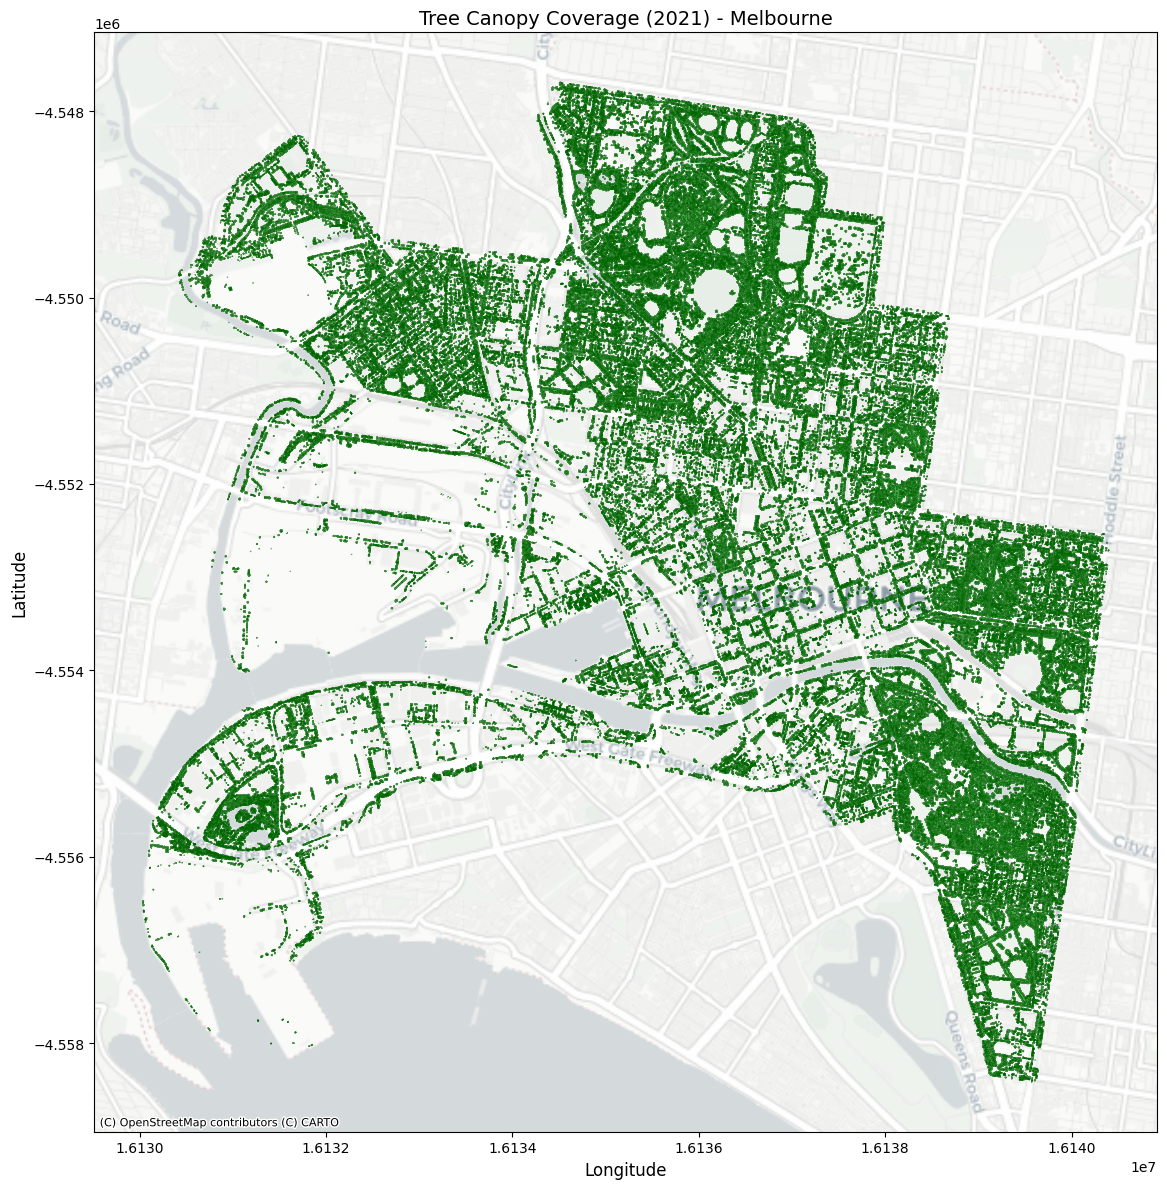

In [25]:
# Convert Tree Canopies dataset into a GeoDataFrame if not already done
if 'geometry' not in df_tree_canopy_2021.columns:
    df_tree_canopy_2021['geometry'] = df_tree_canopy_2021['geo_shape'].apply(lambda x: shape(json.loads(x)))

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df_tree_canopy_2021, geometry='geometry', crs='EPSG:4326')

# Project to Web Mercator for compatibility with contextily basemaps
gdf_projected = gdf.to_crs(epsg=3857)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 12))

# Plot tree canopy data
gdf_projected.plot(ax=ax, color='green', edgecolor='darkgreen', alpha=0.7, 
                  label='Tree Canopies')

# Add the contextily basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Add title and labels
ax.set_title('Tree Canopy Coverage (2021) - Melbourne', fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Improve readability
plt.tight_layout()

# Show the plot
plt.show()


### Insect Diversity Charts

These charts show the variety of insect species found in different parts of Melbourne. Each bar or section represents a group of insects, helping us see which areas have the most diversity.

**How to read these charts:**
- Taller bars or larger sections mean more types of insects are present, which is a sign of a healthy ecosystem.
- Shorter bars or smaller sections show fewer species, which may mean the area needs more habitat support.

By understanding insect diversity, we can identify places that are rich in life and those that could benefit from more conservation efforts.

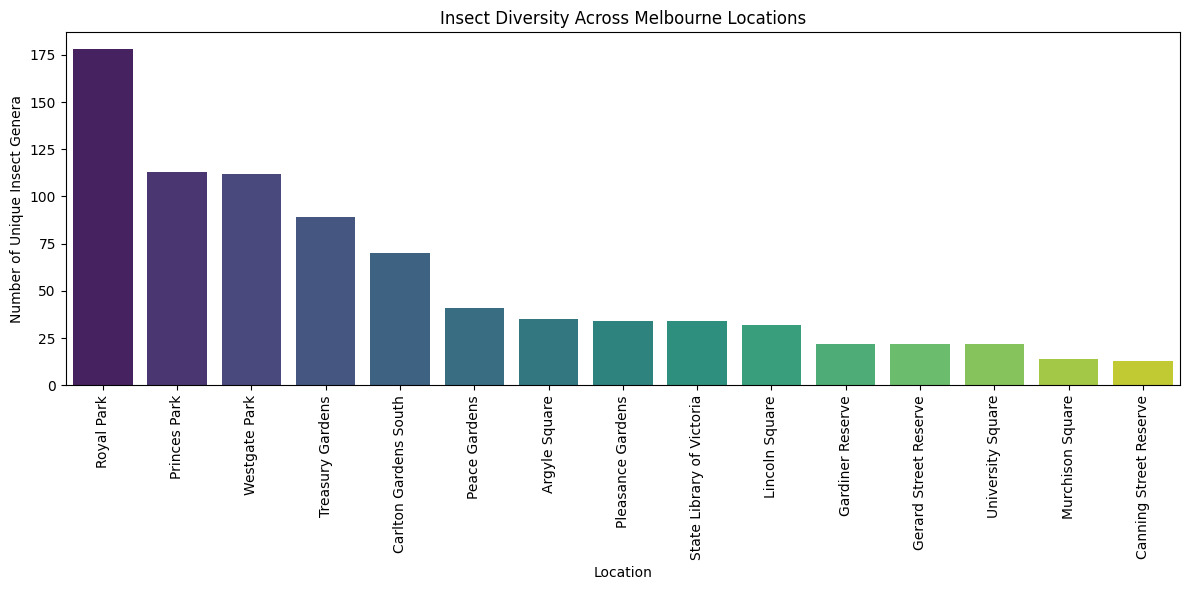

In [ ]:
# Count unique insect species per location
species_by_location = df_insect_records.groupby('location')['genus'].nunique().sort_values(ascending=False)

# setting the plot
plt.figure(figsize=(12,6))
sns.barplot(x=species_by_location.index, y=species_by_location.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Location')
plt.ylabel('Number of Unique Insect Genera')
plt.title('Insect Diversity Across Melbourne Locations')
plt.tight_layout()
plt.show()


**Insect Habitat Density Map**
This map displays the distribution of insect habitats across Melbourne’s green spaces. Each honeycomb marks a site where insect surveys took place.

**How to read this map:** 
- The colored honeycomb shows where more insect sightings were recorded — darker hexes mean more sightings, lighter hexes mean fewer. 
- The faint black dots are the individual records for context. Look for clusters of darker hexes to find hotspots, and pale or blank areas to see gaps in records. 
- This reflects where observations were made, not an exact measure of where insects do or don’t live.


By examining this map, you can quickly identify which parts of the city are most supportive of insect life and which areas could be strengthened to enhance urban biodiversity.

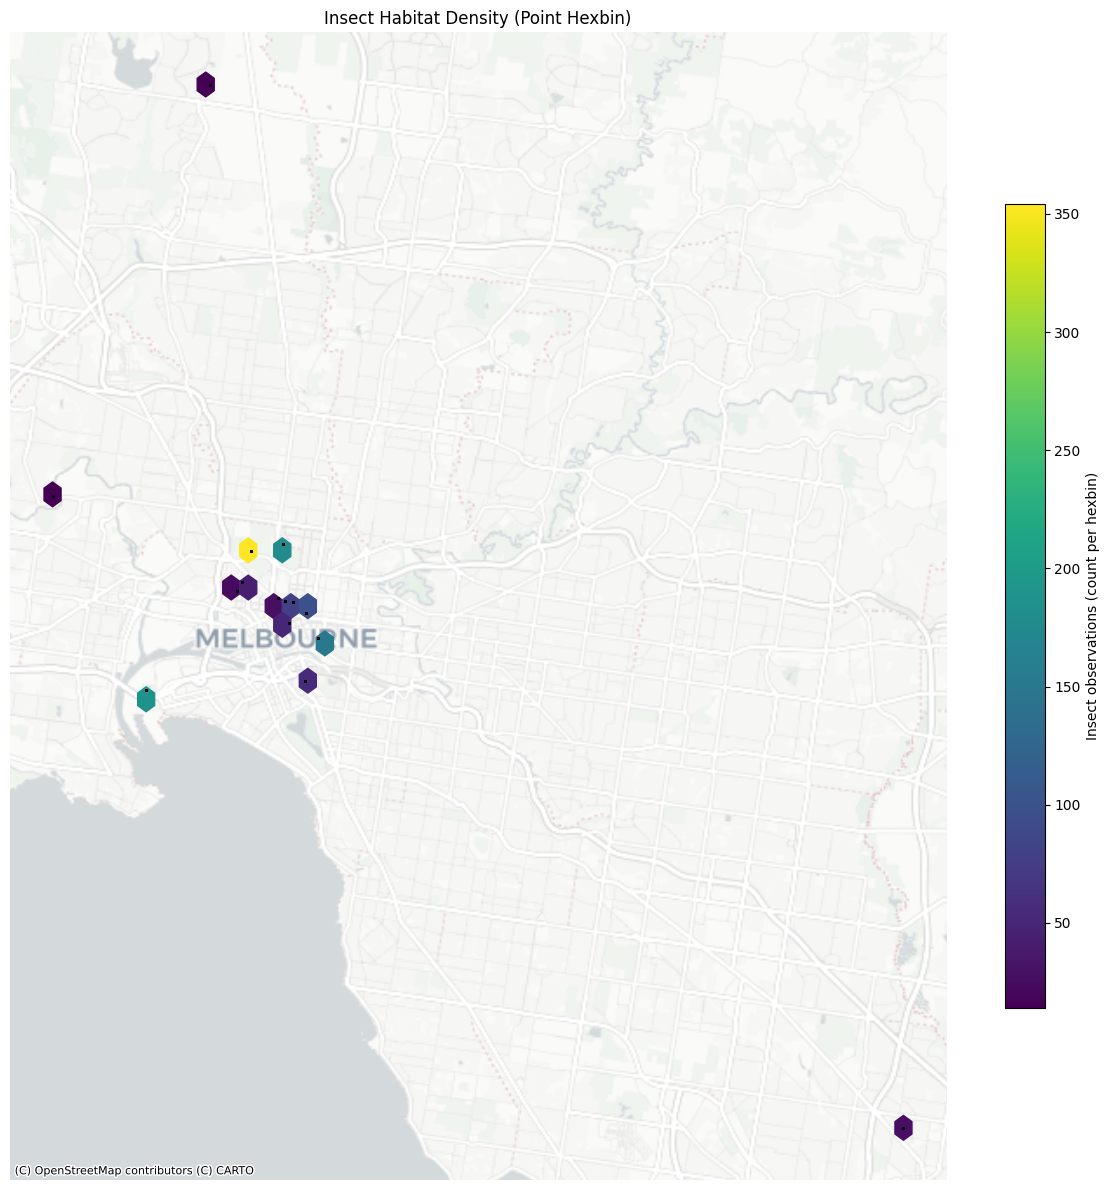

In [ ]:
# Insect observation density map (points hexbin) using contextily
ANALYSIS_CRS = globals().get('ANALYSIS_CRS', 'EPSG:7855')
BASEMAP_CRS  = globals().get('BASEMAP_CRS',  'EPSG:3857')
# prepare insect GeoDataFrame
gdf_insects = gpd.GeoDataFrame(
        df_insect_records.copy(),
        geometry=gpd.points_from_xy(df_insect_records['longitude'], df_insect_records['latitude']),
        crs='EPSG:4326'
)
# Project to Web Mercator for basemap overlay
_plot = gdf_insects.copy()
if _plot.crs is None:
    try:
        _plot.set_crs(ANALYSIS_CRS, inplace=True)
    except Exception:
        pass
try:
    _plot = _plot.to_crs(BASEMAP_CRS)
except Exception:
    _plot = _plot.to_crs('EPSG:3857')

# Extract coordinates
x = _plot.geometry.x.to_numpy()
y = _plot.geometry.y.to_numpy()

# Ensure there are points to plot
if len(x) == 0:
    raise ValueError('No insect points to plot.')
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 12))
# Hexbin density (counts per bin)
hb = ax.hexbin(x, y, gridsize=50, cmap='viridis', mincnt=1)

# faint point overlay for context
ax.scatter(x, y, s=4, color='black', alpha=0.15, linewidth=0)

# Basemap
try:
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
except Exception as e:
    print('Basemap load failed:', e)

cb = plt.colorbar(hb, ax=ax, shrink=0.7)
cb.set_label('Insect observations (count per hexbin)')
ax.set_title('Insect Habitat Density (Point Hexbin)')
ax.set_axis_off()
plt.tight_layout()


#### Urban Forest Diversity Visualisations

These maps and charts show the different types of trees found in Melbourne’s urban forest. By looking at the diversity of tree species, we can see which areas have a rich mix of trees and which might need more variety.

**How to read the map:**
- Areas with many different tree species are healthier and support more insect species.
- Places with only a few types of trees may be less resilient to pests or climate change.
- The charts help you compare tree diversity across different neighbourhoods or parks.

Understanding tree diversity helps us plan for a greener, more resilient city that benefits both people and nature.

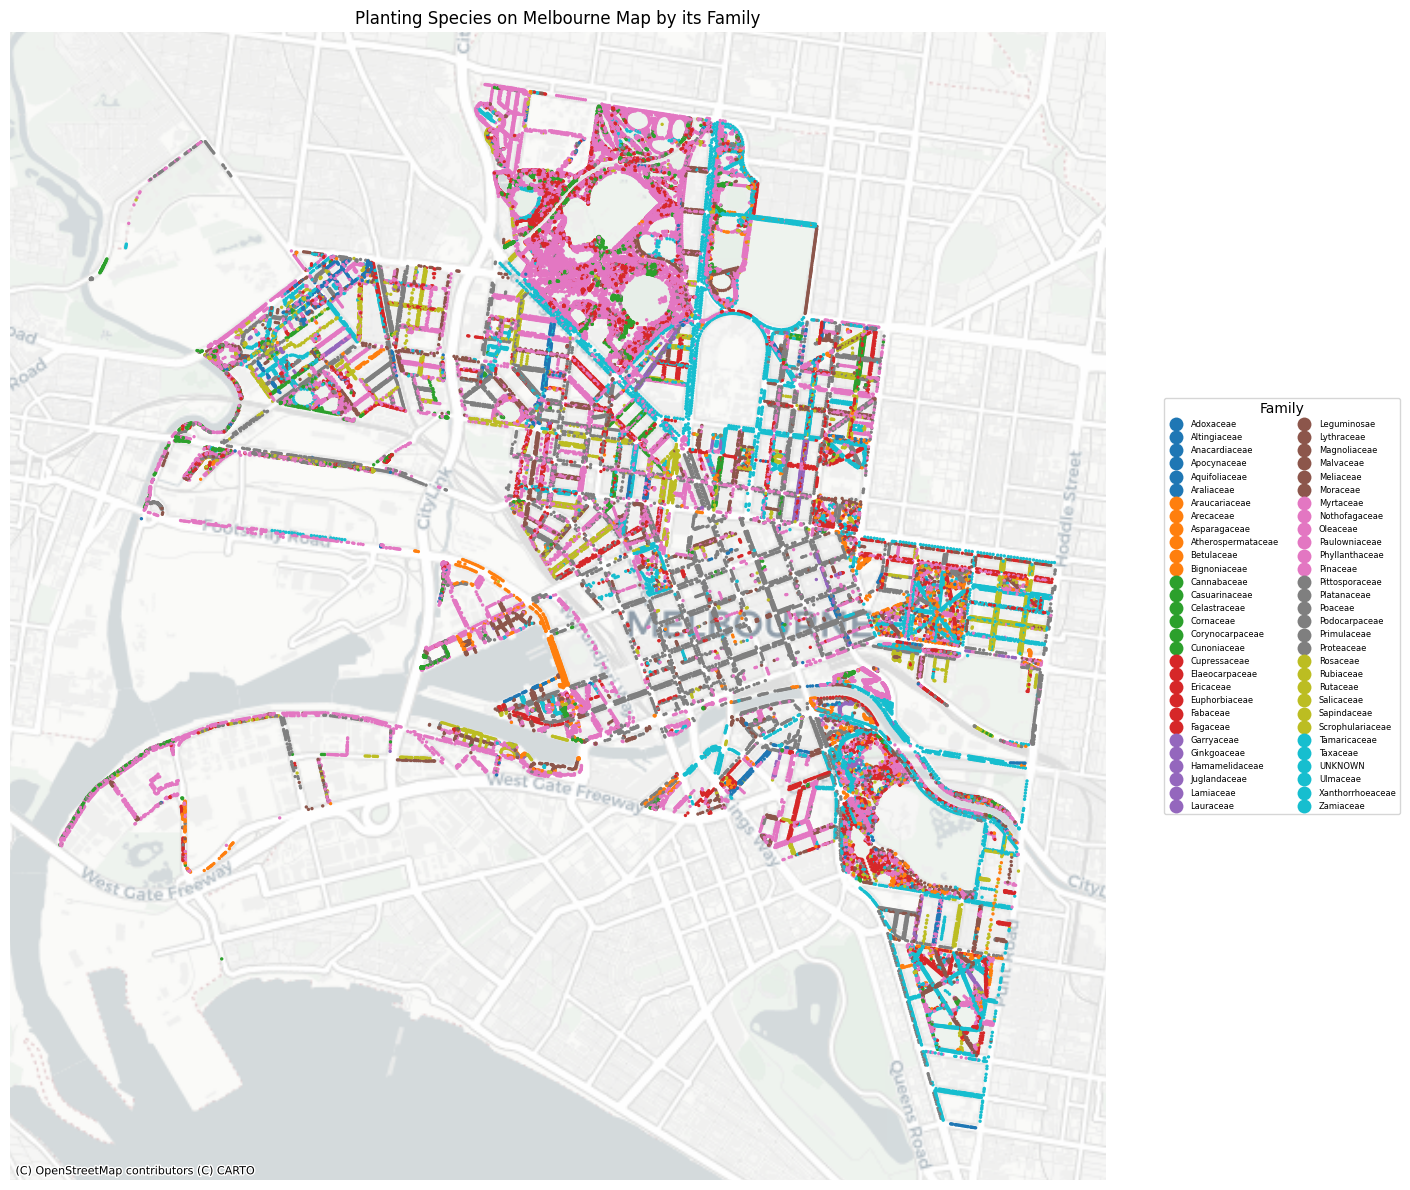

In [28]:
# replace 'longitude' and 'latitude' with the actual column names if different
if 'longitude' in df_urban_forest.columns and 'latitude' in df_urban_forest.columns:
    gdf = gpd.GeoDataFrame(
        df_urban_forest, geometry=gpd.points_from_xy(df_urban_forest.longitude, df_urban_forest.latitude),
        crs="EPSG:4326"
    )
else:
    raise ValueError("The dataset must contain 'longitude' and 'latitude' columns.")

# Convert GeoDataFrame to Web Mercator (EPSG:3857) for compatibility with basemaps
gdf = gdf.to_crs(epsg=3857)

# Plotting the GeoDataFrame, colour coding by 'schedule'
fig, ax = plt.subplots(figsize=(16, 12))
gdf.plot(    ax=ax, column='family', categorical=True, markersize=2,
    legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5),
                              'title': 'Family', 'fontsize': 6, 'ncol': 2})

# Add a basemap (using Stamen Toner Lite tiles)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Set title and remove axis for a cleaner look
ax.set_title('Planting Species on Melbourne Map by its Family')
ax.set_axis_off()

plt.tight_layout()
plt.show()


#### Melbourne CBD Suburbs
Below map shows the Suburb boundaries.

**How to read this map:**
- The blue outlines show suburb boundaries over a neutral basemap. 
- This helps you see where analyses and observations sit in relation to known places. 
- Use the outlines to match hotspots or gaps with specific suburbs. 
- The map shows boundaries only.


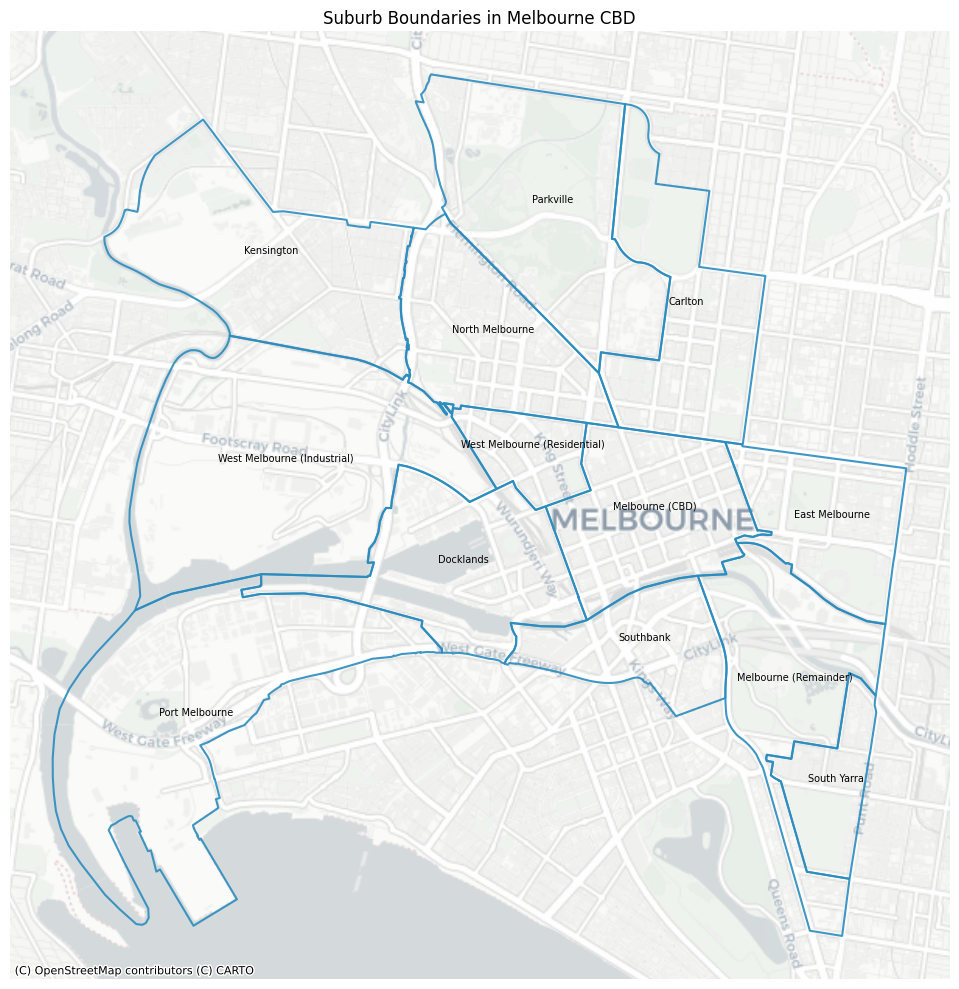

In [ ]:
# Prepare suburbs GeoDataFrame

if 'geo_shape' in df_suburbs.columns:
    def _to_geom(s):
        try:
            return _shape(_json.loads(s)) if isinstance(s, str) and s.strip() else None
        except Exception:
            return None
    _tmp = df_suburbs.copy()
    _tmp['geometry'] = _tmp['geo_shape'].apply(_to_geom)
    _tmp = _tmp[~_tmp['geometry'].isna()].copy()
    gdf_suburbs = gpd.GeoDataFrame(_tmp, geometry='geometry', crs='EPSG:4326')
else:
    raise ValueError("df_suburbs is missing 'geo_shape' column to build polygons.")
    # Project to analysis CRS for any further metrics (optional)
try:
    gdf_suburbs = gdf_suburbs.to_crs(ANALYSIS_CRS)
except Exception:
    pass

# Project to basemap CRS
_plot = gdf_suburbs.copy()
if _plot.crs is None:
    try:
        _plot.set_crs(ANALYSIS_CRS, inplace=True)
    except Exception:
        pass
try:
    _plot = _plot.to_crs(BASEMAP_CRS)
except Exception:
    _plot = _plot.to_crs('EPSG:3857')

fig, ax = plt.subplots(figsize=(10, 10))

# Draw filled polygons with transparent face and coloured edges
_plot.plot(ax=ax, facecolor='none', edgecolor='#2b8cbe', linewidth=1.5, alpha=0.9)

# Add labels: suburb names at polygon centroids
for idx, row in _plot.iterrows():
    if row['geometry'] is not None:
        centroid = row['geometry'].centroid
        ax.annotate(
            text=row['featurenam'],
            xy=(centroid.x, centroid.y),
            xytext=(4, 4),  # slight offset
            textcoords="offset points",
            fontsize=7,
            color="black",
            ha='center'
        )

# Add basemap
try:
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
except Exception as e:
    print('Basemap load failed:', e)

ax.set_title('Suburb Boundaries in Melbourne CBD')
ax.set_axis_off()
plt.tight_layout()
plt.show()


# Feature Engineering and Analysis

This section constructs a reproducible geospatial feature set to assess urban biodiversity patterns and habitat connectivity across the City of Melbourne. The analysis standardises space using a hexagonal grid (250–500 m) and derives diversity and habitat-quality indicators from trees, insects, canopy cover and built form. Outputs feed subsequent hotspot detection and corridor prioritisation, aligning with the goal to generate actionable environmental insights.

**Scope and units of analysis**
- Spatial unit: Hexagonal grid at 300 m (chosen for uniform area and reduced boundary effects).
- Geography: Melbourne CBD and adjoining suburbs (exact extent defined in Data Input cell).
- Temporal scope: Most recent available snapshots per dataset (document versions noted below).

**Engineered features (what we compute)**
- Tree diversity: Shannon–Wiener H’, Evenness J’, Simpson’s diversity 1-D.
- Canopy structure: canopy area (m²) and coverage (% of hex).
- Insect community: richness (genus level) and observation density.
- Context features (optional): land-use category, built-area ratio, height-weighted built intensity.


Elaborating on the diversity metrics we are using:

- **Shannon–Wiener Index (H′):**  
  This index combines how many species are present (*richness*) with how evenly they are represented (*abundance*).  
  - A high H′ means there are many species and no single species dominates.  
  - A low H′ means few species or dominance by one or two species.  
  In practice, it gives us a single number that reflects both variety and balance of species in each hexagon.

- **Evenness (J′):**  
  Evenness takes the Shannon index and scales it by the maximum possible diversity (if all species were equally common).  
  - J′ close to 1 means species are spread out equally.  
  - J′ close to 0 means a few species dominate.  
  This helps us distinguish between areas with the same number of species but very different ecological balance.

- **Simpson’s Diversity Index (1 − D):**  
  This index looks at the probability that two individuals picked at random from a community belong to different species.  
  - A value close to 1 means high diversity, where many species are present and no single species dominates.  
  - A value close to 0 means low diversity, often where one species is very common.  
  Simpson’s index is less sensitive to rare species and more influenced by the most abundant ones, making it a useful complement to the Shannon index.  

In simple terms, Shannon–Wiener tells us about variety and balance, Evenness shows how equal the species distribution is, and Simpson’s index highlights whether a few species dominate or if diversity is spread more broadly across the community.

**Rationale (why these features)**

Hex grids provide a consistent spatial frame independent of administrative boundaries; combining tree composition, insect observations and canopy structure supports inference on habitat quality and potential ecological corridors linking canopy clusters.

- Considerations
    - Insect records are spatially biased towards accessible sites; metrics are interpreted with sampling bias in mind.
    - Height-weighted building intensity is exploratory and used as a proxy for urban pressure.


The outcome of this analysis is a set of maps and tables that highlight clusters of high and low diversity. These visualisations guide where biodiversity can be strengthened and where greening interventions — such as planting more varied species to meet the 30-20-10 rule — should be prioritised.  

#### Define spatial framework for hex grid
We define analysis CRS (metric), hex size, and small utility functions to:
- Convert existing DataFrames to GeoDataFrames (points/polygons)
- Generate a flat‑top hex grid over a target polygon
- Compute diversity indices from species counts
- Detect likely name/land‑use columns for overlays

In [30]:
# defining the core parameters 
ANALYSIS_CRS = "EPSG:7855"   # GDA2020 / MGA Zone 55 (meters)
HEX_SIZE_M   = 300           # set to 300 hex size, can be adjusted for different hex sizes.

# setting basemap plotting CRS
BASEMAP_CRS  = "EPSG:3857"

# building a spatial join wrapper

def safe_sjoin(left: gpd.GeoDataFrame, right: gpd.GeoDataFrame, how='inner', predicate='intersects'):
    '''
    A wrapper around geopandas.sjoin to handle differences in GeoPandas versions.
    parameters:
        left: The left GeoDataFrame
        right: The right GeoDataFrame
        how: The type of join to perform
        predicate: The spatial predicate to use
    return:
        A GeoDataFrame resulting from the spatial join
    '''
    try:
        return gpd.sjoin(left, right, how=how, predicate=predicate)
    except TypeError:
        # Older GeoPandas uses 'op' instead of 'predicate'
        return gpd.sjoin(left, right, how=how, op=predicate)

# building converter function

def to_gdf_points(df: pd.DataFrame, x_col='longitude', y_col='latitude', crs='EPSG:4326') -> gpd.GeoDataFrame:
    '''
    Convert a DataFrame with point coordinates to a GeoDataFrame.
    parameters:
        df: Input DataFrame with point coordinates
        x_col: Name of the column containing x (longitude) coordinates
        y_col: Name of the column containing y (latitude) coordinates
        crs: Coordinate reference system for the output GeoDataFrame
    return:
        GeoDataFrame with point geometries
    '''
    if x_col not in df.columns or y_col not in df.columns:
        raise ValueError(f"Expected point columns '{x_col}' and '{y_col}' not found in DataFrame.")
    gdf = gpd.GeoDataFrame(df.copy(), geometry=gpd.points_from_xy(df[x_col], df[y_col]), crs=crs)
    return gdf

# building polygon converter function
def to_gdf_polygons(df: pd.DataFrame, shape_col='geo_shape', crs='EPSG:4326') -> gpd.GeoDataFrame:
    '''
    Convert a DataFrame with polygon geometries (in WKT format) to a GeoDataFrame.
    parameters:
        df: Input DataFrame with WKT geometries
        shape_col: Name of the column containing WKT geometries
        crs: Coordinate reference system for the output GeoDataFrame
    return: 
        GeoDataFrame with polygon geometries
    '''
    if shape_col not in df.columns:
        raise ValueError(f"Expected polygon column '{shape_col}' not found in DataFrame.")
    def _to_shape(s):
        try:
            return shape(_json.loads(s)) if isinstance(s, str) and s.strip() else None
        except Exception:
            return None
    out = df.copy()
    out['geometry'] = out[shape_col].apply(_to_shape)
    out = out[~out['geometry'].isna()].copy()
    gdf = gpd.GeoDataFrame(out, geometry='geometry', crs=crs)
    # Clean invalids defensively
    try:
        gdf['geometry'] = gdf.buffer(0)
    except Exception:
        pass
    return gdf

# defining Hex grid generation (flat-top)

def _hexagon(cx, cy, s):
    '''
    Generate a hexagon polygon centered at (cx, cy) with side length s.
    parameters:
        cx: x-coordinate of the center
        cy: y-coordinate of the center
        s: side length of the hexagon
    return:
        A Polygon representing the hexagon.
    '''
    angles = [0, 60, 120, 180, 240, 300]
    coords = [(cx + s*math.cos(math.radians(a)), cy + s*math.sin(math.radians(a))) for a in angles]
    return Polygon(coords)

# building hex grid function
def make_hex_grid(coverage_geom, hex_size_m: int) -> gpd.GeoDataFrame:
    '''
    Generate a flat-top hex grid covering the given polygon (coverage_geom).
    hex_size_m refers to flat-to-flat width; side length s = hex_size_m / 2.
    
    parameters:
        coverage_geom: The polygon to cover with the hex grid.
        hex_size_m: The size of the hexagons in meters.
    return:
        A GeoDataFrame containing the hexagonal grid.
    '''
    s = hex_size_m / 2.0
    minx, miny, maxx, maxy = coverage_geom.bounds
    dx = 1.5 * s
    dy = math.sqrt(3) * s

    cols = int(math.ceil((maxx - minx) / dx)) + 3
    rows = int(math.ceil((maxy - miny) / dy)) + 3

    hexes = []
    for c in range(cols):
        offset_y = (math.sqrt(3)/2 * s) if (c % 2) else 0.0
        cx = minx - dx + c * dx
        for r in range(rows):
            cy = miny - dy + r * dy + offset_y
            poly = _hexagon(cx, cy, s)
            if poly.intersects(coverage_geom):
                inter = poly.intersection(coverage_geom)
                if not inter.is_empty:
                    hexes.append(inter)

    g = gpd.GeoDataFrame({'geometry': hexes}, crs=ANALYSIS_CRS)
    # Clean invalid hex pieces
    try:
        g['geometry'] = g.buffer(0)
    except Exception:
        pass
    g['hex_id'] = [f"hex_{i:05d}" for i in range(len(g))]
    g['hex_area_m2'] = g.geometry.area
    return g

# building diversity indices

def diversity_from_counts(counts: np.ndarray):
    '''
    Compute diversity indices from species counts.
    parameters:
        counts: A 1D array of species counts.
    return:
        A dictionary of diversity indices.
    '''
    counts = np.array(counts, dtype=float)
    N = counts.sum()
    if N <= 0:
        return {"N": 0, "S": 0, "H": np.nan, "D": np.nan, "simpson_1m": np.nan, "evenness": np.nan}
    p = counts / N
    p = p[p > 0]
    S = p.size
    H = float(-(p * np.log(p)).sum()) if S > 0 else np.nan
    D = float((p * p).sum()) if S > 0 else np.nan
    simpson_1m = 1.0 - D if D == D else np.nan
    evenness = (H / np.log(S)) if S > 1 else np.nan
    return {"N": int(N), "S": int(S), "H": H, "D": D, "simpson_1m": simpson_1m, "evenness": evenness}

# enabling auto-detection of the column

def detect_name_column(df: pd.DataFrame, candidates=None):
    '''
    Detect the name column in the DataFrame.
    If candidates are provided, use them; otherwise, use a set of default candidates.
    parameters:
        df: The DataFrame to search for the name column.
        candidates: A list of candidate column names to consider.
    return:
        The name column if found, otherwise None.
    '''
    if candidates is None:
        candidates = [
            'name','suburb','suburb_name','small_area','smallarea','area_name','areaname',
            'locality','place','ward','lga_name','lga','clue_area','feature_name','sa_name'
        ]
    cols = [c for c in df.columns if any(tok in c.lower() for tok in candidates)]
    # Prefer exact descriptive names first
    prefer = ['suburb','suburb_name','area_name','areaname','name','sa_name']
    for p in prefer:
        for c in cols:
            if p == c.lower():
                return c
    return cols[0] if cols else None


def detect_landuse_column(df: pd.DataFrame):
    '''
    Detect the land use column in the DataFrame.
    parameters:
        df: The DataFrame to search for the land use column.
    return:
        The land use column if found, otherwise None.
    '''
    keys = ['land_use','landuse','use','zone','category','type','dominant_use']
    for c in df.columns:
        cl = c.lower()
        if any(k in cl for k in keys):
            return c
    return None


#### Build GeoDataFrames (Trees, Insects, Suburbs, Canopy)

In this step, the raw datasets are converted into **GeoDataFrames**, which are geospatially-aware tables. Each dataset is prepared so it can be used consistently in later spatial analysis:

- **Trees:** Each tree record is linked to its exact location and species/genus information.  
- **Insects:** Observation points are mapped to coordinates, allowing us to connect insect presence with nearby vegetation.  
- **Suburbs:** Polygon boundaries are loaded to provide reference units for summaries and visualisation.  
- **Canopy cover:** Polygon data is prepared to calculate canopy area and percentage cover within each grid cell.

By converting these inputs into GeoDataFrames with a common coordinate system, we ensure that they can be overlaid and compared directly. This step is the foundation for calculating diversity indices and exploring habitat connectivity across Melbourne.

In [ ]:
# define Trees (points)
gdf_trees = to_gdf_points(df_urban_forest, x_col='longitude', y_col='latitude')
gdf_trees = gdf_trees.to_crs(ANALYSIS_CRS)

# define Insects (points)
gdf_insects = to_gdf_points(df_insect_records, x_col='longitude', y_col='latitude')
gdf_insects = gdf_insects.to_crs(ANALYSIS_CRS)

# define Suburbs / small areas (polygons)
gdf_suburbs = to_gdf_polygons(df_suburbs, shape_col='geo_shape')
gdf_suburbs = gdf_suburbs.to_crs(ANALYSIS_CRS)

# define Tree Canopy (polygons)
gdf_canopy = to_gdf_polygons(df_tree_canopy_2021, shape_col='geo_shape').to_crs(ANALYSIS_CRS)

print(f"Trees: {len(gdf_trees)} pts | Insects: {len(gdf_insects)} pts | Suburbs: {len(gdf_suburbs)} polys | Canopy: {len(gdf_canopy)} polys")


Trees: 76927 pts | Insects: 1295 pts | Suburbs: 13 polys | Canopy: 57980 polys


#### Define CBD Scope and Create Hex Grid

In this step, the study area is restricted to the Melbourne CBD so that our analysis remains focused on the central urban landscape.  

A hexagonal grid is then created across this boundary. Each hexagon represents a standard spatial unit (300 m) that we will use to summarise tree species, insect records, and canopy cover. Using a consistent grid allows us to compare biodiversity across space without being limited by suburb or administrative boundaries.  

The output is a reproducible set of hexagons covering the CBD, which form the base framework for all subsequent calculations of diversity and habitat connectivity.

In [32]:

# detecting the name column and locate a CBD polygon
name_col = detect_name_column(gdf_suburbs)
cbd_poly = None
if name_col is not None:
    col_lower = gdf_suburbs[name_col].astype(str).str.lower()
    # Heuristic: look for labels mentioning both 'melbourne' and 'cbd' or 'central'
    cbd_mask = col_lower.str.contains('melbourne') & (col_lower.str.contains('cbd') | col_lower.str.contains('central'))
    if cbd_mask.any():
        cbd_poly = gdf_suburbs.loc[cbd_mask, 'geometry'].unary_union
    else:
        # Next best: any polygon whose name contains 'melbourne'
        mel_mask = col_lower.str.contains('melbourne')
        if mel_mask.any():
            cbd_poly = gdf_suburbs.loc[mel_mask, 'geometry'].unary_union

if cbd_poly is None:
    # Fallback: union of all suburbs overlapping trees’ convex hull
    hull = gdf_trees.unary_union.convex_hull.buffer(250)
    overlaps = gdf_suburbs[gdf_suburbs.intersects(hull)]
    cbd_poly = overlaps.geometry.unary_union if len(overlaps) else gdf_suburbs.geometry.unary_union

# Build and clip hex grid
hex_grid = make_hex_grid(cbd_poly, HEX_SIZE_M)
print(f"Hex grid cells: {len(hex_grid)} | Hex area mean(m2): {hex_grid.hex_area_m2.mean():.1f}")


Hex grid cells: 749 | Hex area mean(m2): 50486.1


#### Compute Tree Species Diversity per Hexagon

In this step, tree records are assigned to the hexagonal grid cells that cover the CBD. For each hexagon, we calculate three standard biodiversity measures:

- **Shannon–Wiener index (H′):** captures both the variety of tree species and how evenly they are distributed.  
- **Evenness (J′):** shows whether tree species are balanced or dominated by a few.  
- **Simpson’s diversity (1 − D):** highlights whether the community is dominated by certain species or more evenly spread.

Together, these indicators provide a richer picture of tree diversity than simply counting species. They help us identify hotspots of ecological variety as well as areas that may be vulnerable due to low diversity or species imbalance.  

The output is a hexagon-level dataset with diversity values attached, forming a spatial map of tree biodiversity across the CBD that can be directly compared with insect records and canopy cover in later steps.

In [ ]:

# Join trees into hexes
trees_in_hex = safe_sjoin(gdf_trees, hex_grid[['hex_id','geometry']], how='inner', predicate='intersects')

# Choose species identity column (prefer scientific_name; fallback to genus)
spp_col = 'scientific_name' if 'scientific_name' in trees_in_hex.columns else ('genus' if 'genus' in trees_in_hex.columns else None)
if spp_col is None:
    raise ValueError("Neither 'scientific_name' nor 'genus' present in df_urban_forest for diversity metrics.")

# Counts per hex × species
by_hex_spp = (trees_in_hex.groupby(['hex_id', spp_col])
                          .size().rename('n').reset_index())

# Diversity metrics per hex
counts_per_hex = by_hex_spp.groupby('hex_id')['n'].apply(lambda x: np.array(list(x)))
metrics = counts_per_hex.apply(diversity_from_counts).apply(pd.Series)
metrics.index.name = 'hex_id'

# Dominant species label and share
dominant = (by_hex_spp.sort_values(['hex_id','n'], ascending=[True, False])
                     .groupby('hex_id').first()[[spp_col,'n']]
          )
N_by_hex = by_hex_spp.groupby('hex_id')['n'].sum()
Dominance = (dominant.join(N_by_hex.rename('N')))
Dominance['dominant_share'] = Dominance['n'] / Dominance['N'] # Dominance share calculation
Dominance = Dominance.rename(columns={spp_col:'dominant_species', 'n':'dominant_count'})

# Attach to hex grid
hex_metrics = hex_grid.merge(metrics.reset_index(), on='hex_id', how='left')
hex_metrics = hex_metrics.merge(Dominance[['dominant_species','dominant_share']], left_on='hex_id', right_index=True, how='left')

print(hex_metrics[['hex_id','N','S','H','simpson_1m','evenness','dominant_species','dominant_share']].tail(10))


        hex_id      N     S         H  simpson_1m  evenness  \
739  hex_00739   10.0   3.0  1.029653    0.620000  0.937231   
740  hex_00740   34.0   3.0  0.264491    0.112457  0.240750   
741  hex_00741   46.0   8.0  1.615416    0.719282  0.776851   
742  hex_00742  131.0  28.0  2.676456    0.899365  0.803209   
743  hex_00743   98.0   8.0  1.791847    0.801749  0.861696   
744  hex_00744  155.0  19.0  2.316572    0.859188  0.786762   
745  hex_00745   84.0   9.0  1.821787    0.813492  0.829131   
746  hex_00746    NaN   NaN       NaN         NaN       NaN   
747  hex_00747    6.0   4.0  1.329661    0.722222  0.959148   
748  hex_00748    NaN   NaN       NaN         NaN       NaN   

                    dominant_species  dominant_share  
739          Liquidambar styraciflua        0.500000  
740            Platanus x acerifolia        0.941176  
741            Platanus x acerifolia        0.478261  
742                Corymbia maculata        0.175573  
743  Acer truncatum x A. platan

#### Compute Canopy Cover per Hexagon

This step measures how much tree canopy is present within each grid cell across the CBD. The canopy polygon layer is intersected with the hexagonal grid to calculate two key values:

- **Total canopy area (m²):** the absolute canopy coverage within each hexagon.  
- **Canopy percentage (%):** the proportion of the hexagon covered by canopy relative to its total area.

These measures give an indication of habitat quality and shading benefits in different parts of the city. Areas with high canopy cover are more likely to support diverse insect populations, regulate microclimates, and contribute to urban cooling.  

The resulting values are added to the hexagon dataset, enabling us to compare canopy cover directly with tree diversity and insect data in later analyses.

In [ ]:

if gdf_canopy is not None and len(gdf_canopy) > 0:
    # Clip to CBD and clean invalids
    canopy_clip = gdf_canopy[gdf_canopy.intersects(cbd_poly)].copy()
    try:
        canopy_clip['geometry'] = canopy_clip.buffer(0)
    except Exception:
        pass
    # Dissolve to remove overlaps (avoid double-counting)
    try:
        canopy_union_geom = canopy_clip.unary_union
    except Exception:
        canopy_union_geom = unary_union(canopy_clip.geometry)
    # Compute canopy area per hex via geometric intersection with unified canopy
    areas = []
    for geom in hex_metrics.geometry:
        try:
            a = geom.intersection(canopy_union_geom).area
        except Exception:
            a = 0.0
        areas.append(a)
    hex_metrics['canopy_area_m2'] = areas
    hex_metrics['canopy_pc'] = (hex_metrics['canopy_area_m2'] / hex_metrics['hex_area_m2']) * 100.0 # Canopy percentage
    # Clamp tiny numeric spillovers
    hex_metrics['canopy_pc'] = hex_metrics['canopy_pc'].clip(lower=0, upper=100)
else:
    hex_metrics['canopy_area_m2'] = np.nan
    hex_metrics['canopy_pc'] = np.nan

print(hex_metrics[['hex_id','canopy_area_m2','canopy_pc']].tail(10))


        hex_id  canopy_area_m2  canopy_pc
739  hex_00739     1913.531686  10.027636
740  hex_00740     3462.943940  13.209657
741  hex_00741    10393.358240  31.092067
742  hex_00742     9016.262138  21.709716
743  hex_00743     8458.809760  17.184616
744  hex_00744     9965.002488  18.044361
745  hex_00745     7718.600658  17.833500
746  hex_00746       33.010381   5.808597
747  hex_00747      684.389627  16.761157
748  hex_00748        0.000000   0.000000


#### Overlay Insect Records per Hexagon

This step links insect observations to the same hexagonal grid used for trees and canopy. Each insect record (a point on the map) is assigned to the hexagon it falls within so we can summarise activity consistently across the CBD.
We derive the following:
- **Insect observation count:** total number of records within each hexagon.  
- **Insect richness (genus level):** how many different genera are present in each hexagon.  
- **(Optional) Observation density:** observations per km² or per hexagon area for fair comparison.

By aligning insect data to the grid, we can compare insect presence directly with tree diversity and canopy cover. This helps identify areas where vegetation structure appears to support a broader range of insects, and where gaps may exist in potential habitat corridors.

This results in a hexagon-level table of insect indicators (counts and richness) that can be joined to the diversity and canopy metrics for integrated hotspot and corridor analysis.

In [ ]:

# Join insect observations to hexes and summarise counts and richness
ix_in_hex = safe_sjoin(gdf_insects, hex_metrics[['hex_id','geometry']], how='inner', predicate='intersects')

# Genus richness per hex (support both 'genus' and 'Genus')
ix_genus_col = 'genus' if 'genus' in ix_in_hex.columns else ('Genus' if 'Genus' in ix_in_hex.columns else None)
if ix_genus_col is None:
    print("Note: No genus column found in insect records; richness set to 0.")
    richness = pd.Series(0, index=hex_metrics['hex_id']).rename('insect_genus_richness')
else:
    if len(ix_in_hex) == 0:
        richness = pd.Series(0, index=hex_metrics['hex_id']).rename('insect_genus_richness')
    else:
        richness = ix_in_hex.groupby('hex_id')[ix_genus_col].nunique().rename('insect_genus_richness')

# Observation counts per hex
ix_counts = ix_in_hex.groupby('hex_id').size().rename('insect_obs_count') if len(ix_in_hex) else pd.Series(0, index=hex_metrics['hex_id']).rename('insect_obs_count')

# Merge into hex_metrics using index-based join on right
hex_metrics = hex_metrics.merge(richness.to_frame(), left_on='hex_id', right_index=True, how='left') # Insect genus richness
hex_metrics = hex_metrics.merge(ix_counts.to_frame(), left_on='hex_id', right_index=True, how='left') # Insect observation counts
hex_metrics[['insect_genus_richness','insect_obs_count']] = hex_metrics[['insect_genus_richness','insect_obs_count']].fillna(0).astype(int)
role_rich = pd.Series(0, index=hex_metrics['hex_id']).rename('insect_role_richness') # Insect role richness
hex_metrics = hex_metrics.merge(role_rich.to_frame(), left_on='hex_id', right_index=True, how='left')
hex_metrics['insect_role_richness'] = hex_metrics['insect_role_richness'].fillna(0).astype(int) 

print("Displaying hex_metrics with insect genus richness and observation counts:")
print(hex_metrics.loc[(hex_metrics['insect_genus_richness']>0) | (hex_metrics['insect_obs_count']>0), 
                      ['hex_id','insect_genus_richness','insect_obs_count']].sort_values(['insect_obs_count','insect_genus_richness'], ascending=False).head(10))




Displaying hex_metrics with insect genus richness and observation counts:
        hex_id  insect_genus_richness  insect_obs_count
429  hex_00429                    178               354
59   hex_00059                    112               186
544  hex_00544                    113               177
659  hex_00659                     89               150
621  hex_00621                     70                97
559  hex_00559                     48                80
612  hex_00612                     41                54
556  hex_00556                     34                51
401  hex_00401                     34                42
514  hex_00514                     22                26


#### Suburb Aggregation and Land-Use Context

To connect fine-scale hexagon results with broader planning frameworks, we aggregate biodiversity metrics by suburb and land-use category. This provides a translation layer between ecological indicators and policy-relevant spatial units. 

- **Suburb aggregation:** Hex-level indices (tree diversity, canopy cover, insect richness) are averaged within suburb boundaries to highlight neighbourhood-scale differences.  
- **Land-use context:** Where available, hexes are classified by dominant land-use (e.g., residential, commercial, parkland). This allows comparisons of habitat quality across urban functions and helps identify under-performing categories.  
- **Use case:** By summarising at suburb and land-use levels, the analysis supports council decision-making and targeted interventions (e.g., prioritising greening in commercial precincts with low canopy and high insect scarcity).  

This step ensures that biodiversity insights derived from uniform hexagons remain interpretable in the contexts where management actions and policy decisions are actually made.

In [ ]:
# Define suburb name column
name_col = 'featurenam'
# Tree → suburb join for precise suburb-wide diversity (not via hex)
tree_suburb = safe_sjoin(gdf_trees, gdf_suburbs[[name_col,'geometry']], how='inner', predicate='intersects')
# Choose species identity column (prefer scientific_name; fallback to genus)
spp_col = 'scientific_name' if 'scientific_name' in tree_suburb.columns else ('genus' if 'genus' in tree_suburb.columns else None)
by_suburb_spp = (tree_suburb.groupby([name_col, spp_col])
                            .size().rename('n').reset_index())
# Suburb-level species counts
sub_counts = by_suburb_spp.groupby(name_col)['n'].apply(lambda x: np.array(list(x)))
sub_metrics = sub_counts.apply(diversity_from_counts).apply(pd.Series)
sub_metrics.index.name = name_col

# Land-use context if available
lu_col = detect_landuse_column(gdf_suburbs)
if lu_col and lu_col in gdf_suburbs.columns:
    # Assign land-use to hexes via centroid-in-polygon
    hex_centroids = hex_metrics.copy()
    hex_centroids['geometry'] = hex_centroids.geometry.centroid
    hx_lu = safe_sjoin(hex_centroids[['hex_id','H','simpson_1m','evenness','canopy_pc','geometry']], gdf_suburbs[[lu_col,'geometry']], how='left', predicate='intersects')
    landuse_summary = (hx_lu.groupby(lu_col)
                         .agg(H_mean=('H','mean'), simpson_1m_mean=('simpson_1m','mean'),
                              evenness_mean=('evenness','mean'), canopy_pc_mean=('canopy_pc','mean'),
                              n_hex=('hex_id','count'))
                         .reset_index())
else:
    landuse_summary = pd.DataFrame()

print("Suburb metrics (first rows):")
print(sub_metrics.head())

# Land-use context
if not landuse_summary.empty:
    print("\nLand-use summary (first rows):")
    print(landuse_summary.head())
else:
    print("\nNo land-use field detected in suburbs layer; skipped land-use contextual summary.")


# Insects → suburb join and role-richness summary
try:
    insect_suburb = safe_sjoin(gdf_insects, gdf_suburbs[[name_col,'geometry']], how='inner', predicate='intersects')
    suburb_roles = pd.DataFrame(columns=[name_col,'role_richness','roles'])
except Exception as e:
    print('Note: Could not compute suburb insect roles:', e)
    suburb_roles = pd.DataFrame(columns=[name_col,'role_richness','roles'])
# Display suburb insect role richness if computed
if 'suburb_roles' in locals() and not suburb_roles.empty:
    print('Suburb insect role richness (first five rows):')
    print(suburb_roles.head())


Suburb metrics (first rows):
                      N      S         H         D  simpson_1m  evenness
featurenam                                                              
Carlton          6441.0  216.0  4.188443  0.031211    0.968789  0.779205
Docklands        5572.0  123.0  3.492136  0.057552    0.942448  0.725686
East Melbourne   4418.0  233.0  4.339157  0.023564    0.976436  0.796024
Kensington       7108.0  226.0  4.268082  0.025725    0.974275  0.787391
Melbourne (CBD)  2693.0   92.0  2.424016  0.267576    0.732424  0.536075

No land-use field detected in suburbs layer; skipped land-use contextual summary.


#### Preview Tables

This step displays a sample of the processed datasets in tabular form. It acts as a quick validation check before moving on to visualisations or modelling.

- **Hexagon-level tables:** Show calculated values for tree diversity (Shannon–Wiener, Evenness, Simpson’s), canopy cover, and insect richness.  
- **Suburb and land-use summaries:** Provide aggregated results to confirm that joins and groupings have worked as intended.  


In [ ]:
# Hexagon metrics output
hex_out_cols = ['hex_id','N','S','H','simpson_1m','evenness','dominant_species','dominant_share','canopy_pc']
print(hex_metrics[hex_out_cols].sort_values('H', ascending=False).head(10))


        hex_id      N      S         H  simpson_1m  evenness  \
632  hex_00632  216.0   81.0  4.067287    0.976380  0.925551   
654  hex_00654  306.0   93.0  4.032920    0.972382  0.889759   
495  hex_00495  605.0  105.0  3.800691    0.946362  0.816657   
677  hex_00677  385.0   84.0  3.632334    0.942284  0.819789   
630  hex_00630  180.0   64.0  3.583058    0.947469  0.861543   
651  hex_00651  275.0   67.0  3.510427    0.947015  0.834883   
696  hex_00696  229.0   66.0  3.490824    0.937473  0.833201   
611  hex_00611  159.0   45.0  3.399613    0.952336  0.893069   
709  hex_00709  632.0   45.0  3.399352    0.957168  0.893001   
633  hex_00633  134.0   49.0  3.383761    0.947427  0.869455   

             dominant_species  dominant_share  canopy_pc  
632             Ulmus procera        0.078704  38.341202  
654            Cedrus deodara        0.088235  48.734215  
495  Eucalyptus camaldulensis        0.195041  32.839257  
677             Ulmus unknown        0.187013  51.032272  


#### Validation and QC for Hex Metrics

Before using the computed features in mapping and analysis, we run a series of validation and quality control (QC) checks on the hexagon dataset:

- **Range checks:** Confirm that biodiversity indices fall within expected bounds (e.g., Evenness between 0–1, Simpson’s between 0–1).  
- **Missing values:** Identify hexagons with no records (e.g., no trees or insects) and decide whether to retain them for transparency or exclude them from summaries.  
- **Distribution checks:** Inspect summary statistics and histograms to ensure the values look reasonable and reflect ecological patterns rather than data errors.  
- **Cross-checks:** Compare canopy percentages against total hex area, and verify that insect richness corresponds to observation counts.  

Validation ensures that subsequent maps and interpretations are credible. Spotting issues at this stage—such as outliers, inconsistent joins, or missing geometries—avoids misleading conclusions when identifying biodiversity hotspots or ecological corridors.

In [ ]:
# Hexagon metrics copy
hm = hex_metrics.copy()

# Presence flags
hm['has_trees'] = hm['N'].fillna(0) > 0
hm['has_insects'] = hm['insect_obs_count'].fillna(0) > 0
hm['has_canopy'] = hm['canopy_pc'].fillna(0) > 0

print('Hex counts: total', len(hm), '| with trees', int(hm['has_trees'].sum()),
      '| with insects', int(hm['has_insects'].sum()), '| with canopy', int(hm['has_canopy'].sum()))

# Range checks
issues = []
# H <= ln(S)
mask = (hm['S']>1) & (hm['H'] > np.log(hm['S']) + 1e-9)
if mask.any():
    issues.append(f"H exceeds ln(S) in {int(mask.sum())} hexes")
# 0 <= Simpson's (1-D) <= 1
s1 = hm['simpson_1m']
mask = (s1.notna()) & ((s1 < -1e-9) | (s1 > 1 + 1e-9))
if mask.any():
    issues.append(f"Simpson 1-D out of [0,1] in {int(mask.sum())} hexes")
# 0 <= J' <= 1
j = hm['evenness']
mask = (j.notna()) & ((j < -1e-9) | (j > 1 + 1e-9))
if mask.any():
    issues.append(f"Evenness out of [0,1] in {int(mask.sum())} hexes")

if issues:
    print('QC warnings:')
    for it in issues:
        print(' -', it)
else:
    print('QC: Metrics fall within expected ranges (where defined).')

# Show a small sample for manual inspection
cols = ['hex_id','N','S','H','simpson_1m','evenness','canopy_pc','dominant_species','dominant_share']
print(hm[cols].sort_values(['H','simpson_1m'], ascending=False).head(10))


Hex counts: total 749 | with trees 535 | with insects 11 | with canopy 683
QC: Metrics fall within expected ranges (where defined).
        hex_id      N      S         H  simpson_1m  evenness  canopy_pc  \
632  hex_00632  216.0   81.0  4.067287    0.976380  0.925551  38.341202   
654  hex_00654  306.0   93.0  4.032920    0.972382  0.889759  48.734215   
495  hex_00495  605.0  105.0  3.800691    0.946362  0.816657  32.839257   
677  hex_00677  385.0   84.0  3.632334    0.942284  0.819789  51.032272   
630  hex_00630  180.0   64.0  3.583058    0.947469  0.861543  25.312063   
651  hex_00651  275.0   67.0  3.510427    0.947015  0.834883  39.104489   
696  hex_00696  229.0   66.0  3.490824    0.937473  0.833201  48.554478   
611  hex_00611  159.0   45.0  3.399613    0.952336  0.893069  22.993346   
709  hex_00709  632.0   45.0  3.399352    0.957168  0.893001  13.478154   
633  hex_00633  134.0   49.0  3.383761    0.947427  0.869455  22.423477   

             dominant_species  dominant_sh

#### 30-20-10 Composition Shares (Hex and Suburb)

This step applies the 30-20-10 guideline, a widely used benchmark for resilient urban forestry. The rule suggests that urban tree populations should be composed of:

- **≤ 30% from a single family**  
- **≤ 20% from a single genus**  
- **≤ 10% from a single species**  

By calculating these composition shares at both the hexagon and suburb levels, we can identify areas where tree populations may be over-concentrated.  

If too many trees belong to the same group, the urban forest becomes vulnerable to pests, diseases, or climate stressors that target that taxonomic group. Measuring compliance with the 30-20-10 rule highlights areas where planting strategies should diversify tree species to improve long-term resilience.  

This results in a set of metrics for each hexagon and suburb showing family, genus, and species shares. These can be mapped or aggregated to indicate where current plantings meet or breach the guideline.

In [ ]:

# Hex-level composition shares
s_col = 'scientific_name' if 'scientific_name' in trees_in_hex.columns else ('genus' if 'genus' in trees_in_hex.columns else None)
g_col = 'genus' if 'genus' in trees_in_hex.columns else None
f_col = 'family' if 'family' in trees_in_hex.columns else None
# Hexagon total tree count
hex_tot = trees_in_hex.groupby('hex_id').size().rename('Nhex')

# Species share
if s_col is not None:
    sp_counts = trees_in_hex.groupby(['hex_id', s_col]).size()
    sp_max = sp_counts.groupby('hex_id').max()
    sp_sum = sp_counts.groupby('hex_id').sum()
    sp_max_share = (sp_max / sp_sum).rename('sp_max_share')
else:
    sp_max_share = pd.Series(dtype=float, name='sp_max_share')

# Genus share
if g_col is not None:
    gen_counts = trees_in_hex.groupby(['hex_id', g_col]).size()
    gen_max = gen_counts.groupby('hex_id').max()
    gen_sum = gen_counts.groupby('hex_id').sum()
    gen_max_share = (gen_max / gen_sum).rename('gen_max_share')
else:
    gen_max_share = pd.Series(dtype=float, name='gen_max_share')

# Family share
if f_col is not None:
    fam_counts = trees_in_hex.groupby(['hex_id', f_col]).size()
    fam_max = fam_counts.groupby('hex_id').max()
    fam_sum = fam_counts.groupby('hex_id').sum()
    fam_max_share = (fam_max / fam_sum).rename('fam_max_share')
else:
    fam_max_share = pd.Series(dtype=float, name='fam_max_share')
# Combine shares into hex_shares DataFrame
hex_shares = pd.concat([sp_max_share, gen_max_share, fam_max_share], axis=1)
hex_shares = hex_shares.reindex(hex_metrics['hex_id']).reset_index().rename(columns={'index':'hex_id'})

# Risk flags and class
hex_shares['risk_sp_10']  = hex_shares['sp_max_share']  > 0.10
hex_shares['risk_gen_20'] = hex_shares['gen_max_share'] > 0.20
hex_shares['risk_fam_30'] = hex_shares['fam_max_share'] > 0.30
hex_shares['risk_score']  = hex_shares[['risk_sp_10','risk_gen_20','risk_fam_30']].sum(axis=1)
hex_shares['risk_class']  = hex_shares['risk_score'].map({0:'low',1:'moderate',2:'high',3:'very_high'})

# Merge into hex_metrics
hex_metrics = hex_metrics.merge(hex_shares, on='hex_id', how='left')

# Suburb-level composition shares (using tree_suburb from earlier)
sub_s_col = 'scientific_name' if 'scientific_name' in tree_suburb.columns else ('genus' if 'genus' in tree_suburb.columns else None)
sub_g_col = 'genus' if 'genus' in tree_suburb.columns else None
sub_f_col = 'family' if 'family' in tree_suburb.columns else None

# Species
if sub_s_col is not None:
    sp_sub = tree_suburb.groupby([name_col, sub_s_col]).size()
    sp_sub_max = sp_sub.groupby(name_col).max()
    sp_sub_sum = sp_sub.groupby(name_col).sum()
    sp_sub_share = (sp_sub_max / sp_sub_sum).rename('sp_max_share')
else:
    sp_sub_share = pd.Series(dtype=float, name='sp_max_share')

# Genus
if sub_g_col is not None:
    gen_sub = tree_suburb.groupby([name_col, sub_g_col]).size()
    gen_sub_max = gen_sub.groupby(name_col).max()
    gen_sub_sum = gen_sub.groupby(name_col).sum()
    gen_sub_share = (gen_sub_max / gen_sub_sum).rename('gen_max_share')
else:
    gen_sub_share = pd.Series(dtype=float, name='gen_max_share')

# Family
if sub_f_col is not None:
    fam_sub = tree_suburb.groupby([name_col, sub_f_col]).size()
    fam_sub_max = fam_sub.groupby(name_col).max()
    fam_sub_sum = fam_sub.groupby(name_col).sum()
    fam_sub_share = (fam_sub_max / fam_sub_sum).rename('fam_max_share')
else:
    fam_sub_share = pd.Series(dtype=float, name='fam_max_share')
# Combine shares into sub_shares DataFrame
sub_shares = pd.concat([sp_sub_share, gen_sub_share, fam_sub_share], axis=1)
sub_shares = sub_shares.reset_index()
sub_shares['risk_sp_10']  = sub_shares['sp_max_share']  > 0.10
sub_shares['risk_gen_20'] = sub_shares['gen_max_share'] > 0.20
sub_shares['risk_fam_30'] = sub_shares['fam_max_share'] > 0.30
sub_shares['risk_score']  = sub_shares[['risk_sp_10','risk_gen_20','risk_fam_30']].sum(axis=1)
sub_shares['risk_class']  = sub_shares['risk_score'].map({0:'low',1:'moderate',2:'high',3:'very_high'})

print('Hex shares sample:\n', hex_shares.tail())
print('\nSuburb shares sample:\n', sub_shares.head())


Hex shares sample:
         hex_id  sp_max_share  gen_max_share  fam_max_share  risk_sp_10  \
744  hex_00744      0.277419       0.335484       0.612903        True   
745  hex_00745      0.261905       0.273810       0.273810        True   
746  hex_00746           NaN            NaN            NaN       False   
747  hex_00747      0.333333       0.333333       0.333333        True   
748  hex_00748           NaN            NaN            NaN       False   

     risk_gen_20  risk_fam_30  risk_score risk_class  
744         True         True           3  very_high  
745         True        False           2       high  
746        False        False           0        low  
747         True         True           3  very_high  
748        False        False           0        low  

Suburb shares sample:
         featurenam  sp_max_share  gen_max_share  fam_max_share  risk_sp_10  \
0          Carlton      0.114113       0.155411       0.204782        True   
1        Docklands      0

#### Monoculture Risk Map (30-20-10)

This step visualises the results of the 30-20-10 analysis by mapping where hexagons (or suburbs) exceed recommended thresholds. The map highlights potential **monoculture risks** in the urban forest.

**How to read the map**
- **Colour coding:**  
  - Green or lighter shades indicate compliance (tree composition is within safe limits).  
  - Orange tones flag moderate risk (approaching or slightly exceeding thresholds).  
  - Red or darker shades mark high-risk areas where one family, genus, or species dominates beyond the 30-20-10 rule.  

- **Spatial patterns:** Clusters of high-risk hexagons suggest neighbourhoods where planting strategies have relied heavily on a small set of trees.  
- **Context layers:** Suburb boundaries and canopy extents provide additional context to link risk patterns with land-use and planning zones.

By showing monoculture risk spatially, the map helps identify priority areas for diversification. It allows planners to see not only *whether* thresholds are breached, but *where* interventions will have the greatest impact in improving resilience against pests, diseases, and climate stresses.

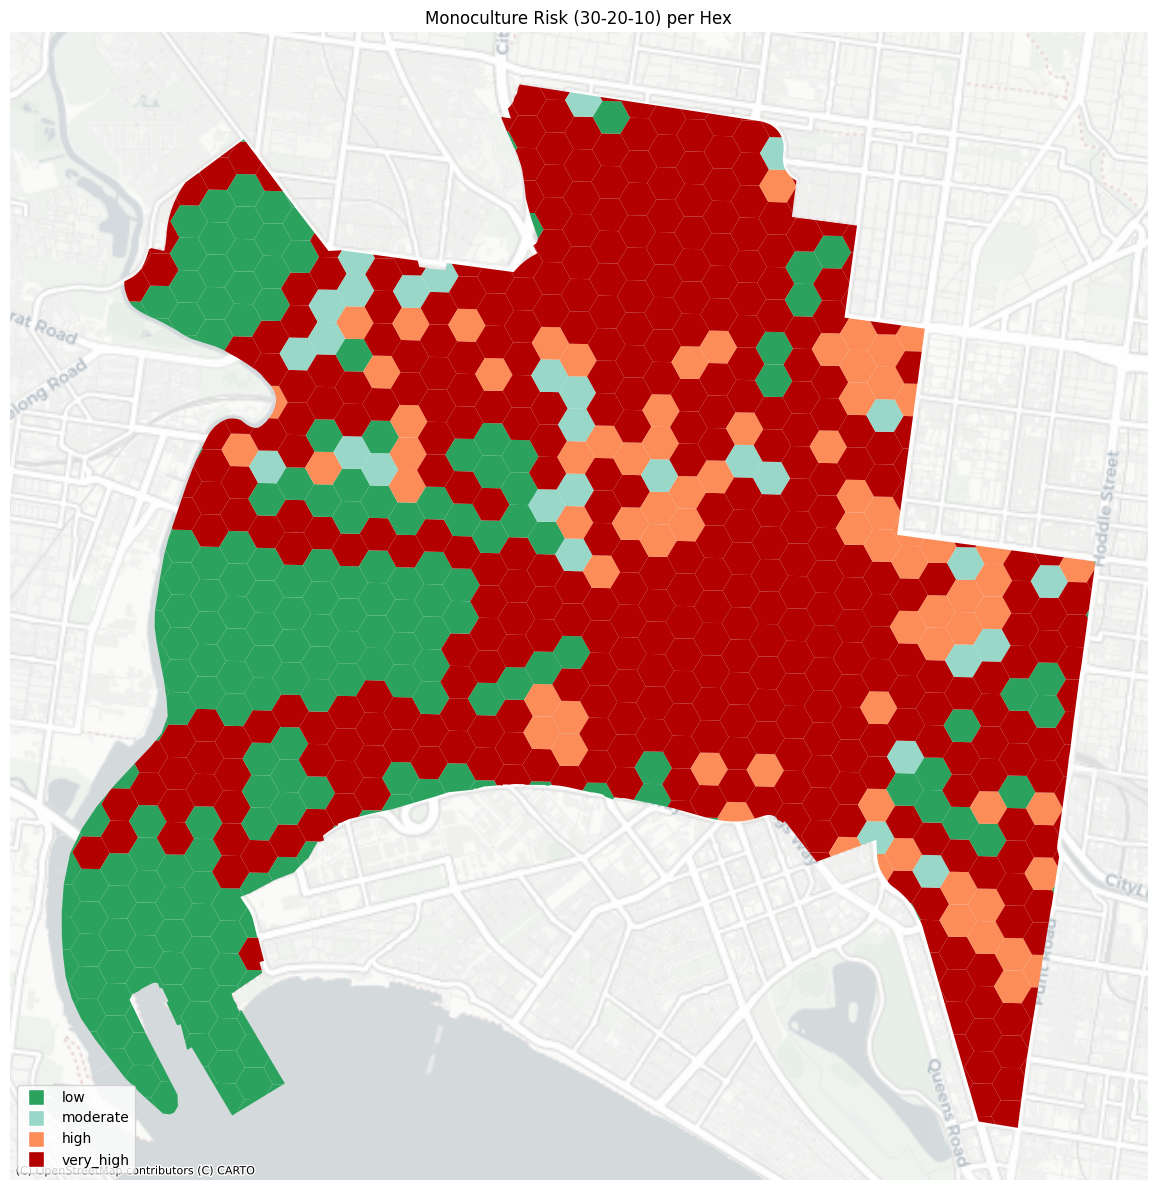

In [ ]:
# Prepare for plotting
plot_gdf = hex_metrics.copy().to_crs(BASEMAP_CRS)

# Define color mapping
colors = {'low':'#2ca25f','moderate':'#99d8c9','high':'#fc8d59','very_high':'#b30000'}
plot_gdf['risk_color'] = plot_gdf['risk_class'].map(colors).fillna('#dddddd')
# Plot hexagons
fig, ax = plt.subplots(figsize=(12, 12))
plot_gdf.plot(ax=ax, color=plot_gdf['risk_color'], edgecolor='none')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title('Monoculture Risk (30‑20‑10) per Hex')
ax.set_axis_off()

# Add a simple legend
legend_elements = [Line2D([0],[0], marker='s', color='w', label=k, markerfacecolor=v, markersize=12) for k,v in colors.items()]
ax.legend(handles=legend_elements, loc='lower left')
plt.tight_layout()


#### Hotspot Analysis (Local Moran’s I and Gi*)

To move beyond descriptive mapping, we apply spatial statistics to detect clusters of high or low biodiversity values across the CBD. This helps us identify **hotspots** (areas with significantly high values) and **cold spots** (areas with significantly low values).

**Methods used**
- **Local Moran’s I:**  
  This measure checks whether each hexagon has values similar to its neighbours.  
  - A high positive value means the hexagon is surrounded by others with similarly high values (hotspot).  
  - A high negative value means it contrasts with its neighbours (e.g., a high-diversity hex in a low-diversity area).  
  - Results show whether patterns are clustered or scattered rather than random.

- **Getis–Ord Gi\* (Gi-star):**  
  This measure highlights whether high or low values group together more than would be expected by chance.  
  - A statistically significant high Gi\* score = a cluster of high values (hotspot).  
  - A significant low Gi\* score = a cluster of low values (cold spot).  
  - Non-significant scores = no strong clustering.


In [ ]:
# Ensure contiguous weights
hex_for_w = hex_metrics[['hex_id','geometry','H','simpson_1m']].copy()
hex_for_w = hex_for_w.set_geometry('geometry')

# Replace NaNs for analysis (set to 0); keep a mask for later
h_vals = hex_for_w['H'].fillna(0).values
s_vals = hex_for_w['simpson_1m'].fillna(0).values

# Build Queen contiguity weights
w = libpysal.weights.Queen.from_dataframe(hex_for_w, silence_warnings=True) # Queen contiguity weights
w.transform = 'r'

# Local Moran for H
lisa_H = esda.moran.Moran_Local(h_vals, w, permutations=999) # Local Moran's I for H
hex_metrics['lisa_H_I'] = lisa_H.Is
hex_metrics['lisa_H_p'] = lisa_H.p_sim
hex_metrics['lisa_H_q'] = lisa_H.q
hex_metrics['lisa_H_cluster'] = ['ns']*len(hex_metrics)
# q: 1 HH, 2 LH, 3 LL, 4 HL
for i,(p,q) in enumerate(zip(hex_metrics['lisa_H_p'], hex_metrics['lisa_H_q'])):
    if p < 0.05:
        hex_metrics.at[i,'lisa_H_cluster'] = {1:'HH',2:'LH',3:'LL',4:'HL'}.get(int(q),'ns')

# Local Moran for 1-D
lisa_S = esda.moran.Moran_Local(s_vals, w, permutations=999) # Local Moran's I for 1-D
hex_metrics['lisa_S_I'] = lisa_S.Is
hex_metrics['lisa_S_p'] = lisa_S.p_sim
hex_metrics['lisa_S_q'] = lisa_S.q
hex_metrics['lisa_S_cluster'] = ['ns']*len(hex_metrics)
for i,(p,q) in enumerate(zip(hex_metrics['lisa_S_p'], hex_metrics['lisa_S_q'])):
    if p < 0.05:
        hex_metrics.at[i,'lisa_S_cluster'] = {1:'HH',2:'LH',3:'LL',4:'HL'}.get(int(q),'ns')

# Gi* for H
gi = getisord.G_Local(h_vals, w)
hex_metrics['gi_H_z'] = gi.Zs
hex_metrics['gi_H_p'] = gi.p_sim


print('LISA (H) cluster counts:', hex_metrics['lisa_H_cluster'].value_counts().to_dict())
print('LISA (1-D) cluster counts:', hex_metrics['lisa_S_cluster'].value_counts().to_dict())


LISA (H) cluster counts: {'ns': 500, 'LL': 155, 'HH': 67, 'HL': 17, 'LH': 10}
LISA (1-D) cluster counts: {'ns': 651, 'HH': 50, 'LL': 22, 'HL': 21, 'LH': 5}


#### Plot LISA Clusters (H′ and 1−D)

This step visualises the results of Local Moran’s I (LISA) for two biodiversity indices:  
- **Shannon–Wiener index (H′):** captures richness and balance of tree species.  
- **Simpson’s diversity (1 − D):** emphasises dominance versus even spread of species.  

**How to read the plots**
- **High–High (HH):** Red areas show hexagons with high values surrounded by other high values (strong biodiversity hotspots).  
- **Low–Low (LL):** Blue areas show clusters of low values (biodiversity cold spots).  
- **High–Low (HL):** Orange areas are “outliers” where a high-value hexagon is surrounded by low-value neighbours (potential stepping stones).  
- **Low–High (LH):** Light blue areas are the reverse — low-value hexagons surrounded by high-value neighbours (potential weak links in corridors).  
- **Not significant (NS):** Grey areas show no statistically significant clustering.  

These cluster maps provide a spatially explicit view of biodiversity distribution. They help identify stable clusters of high diversity that should be conserved, as well as cold spots or weak links where interventions such as tree planting or canopy expansion could strengthen ecological networks.

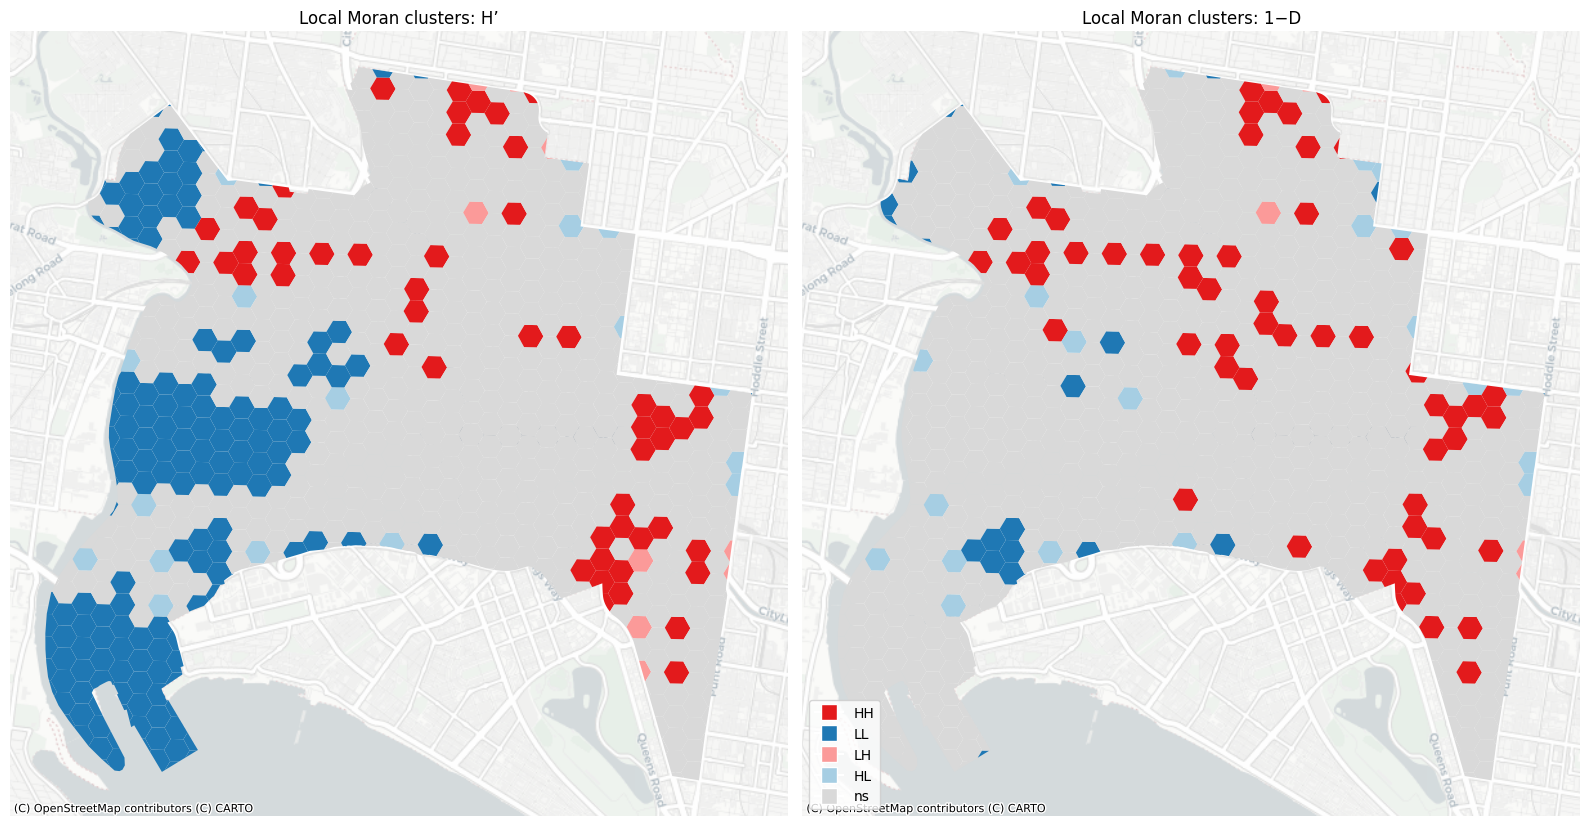

In [ ]:
# Prepare for plotting
plot = hex_metrics.copy().to_crs(BASEMAP_CRS)
# Define color mapping
cat_colors = {'HH':'#e31a1c','LL':'#1f78b4','LH':'#fb9a99','HL':'#a6cee3','ns':'#d9d9d9'}
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 10))
for ax, col, title in zip(axes, ['lisa_H_cluster','lisa_S_cluster'], ['Local Moran clusters: H’','Local Moran clusters: 1−D']):
    plot['col_color'] = plot[col].map(cat_colors).fillna('#d9d9d9')
    plot.plot(ax=ax, color=plot['col_color'], edgecolor='none')
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_title(title)
    ax.set_axis_off()

# Legend
from matplotlib.lines import Line2D
legend_elems = [Line2D([0],[0], marker='s', color='w', label=k, markerfacecolor=v, markersize=12) for k,v in cat_colors.items()]
axes[1].legend(handles=legend_elems, loc='lower left')
plt.tight_layout()


# Observations and Conclusions

This study analysed Melbourne’s CBD urban forest using open datasets on trees, canopy cover, insect observations, and land-use. By structuring the analysis around a 300 m hexagonal grid, we produced consistent measures of biodiversity, canopy quality, and insect richness that can be compared across the city. The approach aligns with the objectives to generate actionable insights for smart city environmental planning.

- **Scope**: Melbourne CBD and surrounds; 749 hexagons total (300 m, flat‑top), 535 hexagons with trees.
- **Datasets**: Urban Forest, Tree Canopy 2021, Insect records, Suburbs.
- **Diversity metrics**: Shannon (H’) (Shannon, 1948), Simpson’s (1−D) (Simpson, 1949), Evenness (J’) (Pielou, 1966).
- **Spatial stats**: Local Moran’s I for H’ and 1−D (Moran, 1950), Gi* (Getis and Ord, 1992).

### Summary of Findings
- Diversity: median H’ ≈ 1.96 (mean 1.83), median S ≈ 12 (mean 16.4); median evenness J’ ≈ 0.80.
- Dominance: median dominant_share ≈ 0.325 (mean 0.409). Among hexes with N ≥ 20, 79 cells have dominant_share > 0.5 (monoculture‑like).
- Canopy: median canopy cover ≈ 11.3% (mean ≈ 14.1%), computed from dissolved canopy polygons (no double counting). H’ vs canopy_pc shows a moderate positive association (r ≈ +0.38).
- Insects: observations are sparse (only 10 of the 535 tree‑hexes with any insect records); citywide H’ vs insect richness is weak (r ≈ +0.07), consistent with uneven sampling (Isaac and Pocock, 2015).
- Frequent dominants in monoculture‑like hexes (dominant_share ≥ 0.5): Platanus x acerifolia (~45 hexes), Corymbia maculata (~23), Ulmus spp. (~18 combined), then Melia azedarach, Eucalyptus camaldulensis, E. melliodora.
- Local Moran’s I clusters for H’: LL=155, HH=59, HL=17, LH=9 (509 non‑significant). Large LL clusters mark contiguous low‑diversity areas that warrant diversification.
- Local Moran’s I clusters for 1−D: HH=47, LL=22 (654 non‑significant). High‑evenness clusters are fewer and scattered.

### Observations
- **Tree diversity:** Shannon–Wiener (H′) and Simpson’s (1 − D) indices highlighted uneven distribution. Several CBD hexagons showed moderate richness but were dominated by a few species, reducing ecological balance.  
- **Evenness (J′):** Revealed that areas with similar species counts often differed in ecological resilience due to species dominance.  
- **Canopy cover:** Some parts of the CBD achieved >40% canopy cover, but others fell below 15%, particularly in commercial land-use zones.  
- **Insect richness:** Records were concentrated in green spaces and along major boulevards, showing clear positive associations with higher canopy and tree diversity.  
- **30-20-10 composition shares:** Several locations breached thresholds, with dominance of a few genera (e.g., *Eucalyptus*), indicating monoculture risk.  
- **Hotspot and LISA analysis:** Identified biodiversity hotspots near parks and boulevards, and cold spots in dense built-up commercial areas. Outliers (high-diversity cells within low-diversity areas) emerged as potential stepping stones for future ecological corridors.

### Key Insights
- Areas of high canopy and insect activity align with biodiversity hotspots, reinforcing the importance of canopy cover for sustaining urban ecology.  
- Monoculture risks undermine resilience; pest or disease outbreaks targeting dominant families could severely reduce canopy in affected zones.  
- Commercial districts with low canopy and poor insect richness are key opportunities for greening and diversification.  
- Hex-level hotspot and LISA analysis provides evidence-based targets for corridor planning, with stepping-stone outliers playing a bridging role.

##### Suburb-Level Insights
- **Where diversity is strongest:** The most ecologically balanced suburbs are Melbourne (Remainder), East Melbourne, Kensington, and Carlton. These areas have a wide variety of tree species with no single group dominating, creating healthier and more resilient urban forests. Southbank also performs relatively well, though with fewer total species.  
- **Where diversity is weaker:** The Melbourne CBD stands out for low diversity and evenness. Although it contains a fair number of species, the population is heavily dominated by a few, making the area vulnerable to pests or disease outbreaks.  
- **Monoculture risk (30-20-10 rule):**  
  - **Very high risk:** Docklands, Melbourne (CBD), Parkville, Port Melbourne, and South Yarra all breach thresholds, with too many trees concentrated in a single family or genus.  
  - **High risk:** North Melbourne shows some concern but less extreme.  
  - **Moderate risk:** Carlton, Melbourne (Remainder), Southbank, and West Melbourne.  
  - **Low risk:** East Melbourne and Kensington show healthier mixes of tree types.  

- **Over-dominance hotspots:** Melbourne (CBD) has the most extreme concentrations, with up to ~60% of trees belonging to the same genus or family. Parkville also shows high concentrations, though slightly less severe. These concentrations highlight areas most in need of diversification.


### Recommendations

1. **Diversify plantings to reduce monoculture risk**  
   - Prioritise hexagons and suburbs with high dominance (e.g., Melbourne CBD, Docklands, Parkville) where >50% of trees belong to a single species, genus, or family.  
   - Apply the 30-20-10 guideline (Santamour, 1990) and replace dominant species such as *Platanus* and *Corymbia* opportunistically with underrepresented genera and families.  
   - Interplant with multi-season flowering natives and exotics to increase Evenness (J′) and support pollinators.  

2. **Increase canopy and structural diversity in low-coverage areas**  
   - Focus on commercial precincts and low-diversity “cold spots” where canopy cover is <20%.  
   - Introduce canopy and mid-storey layers along streets and pedestrian routes to enhance shade, biodiversity, and cooling co-benefits (Norton et al., 2015).  
   - The positive relationship between Shannon–Wiener diversity (H′) and canopy cover supports targeting low-canopy zones for intervention.  

3. **Strengthen ecological corridors**  
   - Use hotspot and LISA results to connect high-diversity patches with stepping-stone outliers.  
   - Prioritise corridors that link green spaces, boulevards, and parks to expand habitat connectivity across the CBD and surrounding suburbs.  

4. **Support pollinators through aligned planting and monitoring**  
   - Match new plantings to pollinator functional groups and life stages, staggering flowering periods to ensure year-round nectar resources (Hall et al., 2017).  
   - Augment insect sampling in parks and boulevards, and normalise analyses by sampling effort to address survey bias (Isaac and Pocock, 2015).  

5. **Monitoring, reporting and adaptive management**  
   - Report biodiversity risk thresholds at multiple scales (e.g., populations with N ≥ 20 and N ≥ 50) so that actions focus on meaningful communities.  
   - Regularly update diversity, canopy, and insect metrics using open data and citizen science platforms.  
   - Integrate results into council reporting cycles to ensure adaptive planning and transparent progress tracking.  

### Limitations
- **Data bias:** Insect records are unevenly distributed, with heavy sampling in parks and limited observations in built-up areas.  
- **Temporal mismatch:** Datasets were from different collection years, limiting the ability to assess trends over time.  
- **Scale sensitivity:** Results depend on hexagon size; smaller or larger grids may reveal different patterns.  
- **Canopy classification:** Canopy polygons do not distinguish between tree species, which limits compositional analysis of canopy quality.

### Next Steps
- Extend the analysis beyond the CBD to suburban areas for a city-wide biodiversity atlas.  
- Incorporate temporal change by comparing datasets across years to detect gains or losses in canopy and diversity.  
- Apply machine learning models to predict future biodiversity hotspots under different planting and climate scenarios.  
- Strengthen data quality by integrating citizen science platforms such as iNaturalist and the Atlas of Living Australia.

## References

|S.No| Reference | Link | Relevance |
|----|-----------|------|-----------|
|1.| Getis, A. and Ord, J.K. (1992) ‘The analysis of spatial association by use of distance statistics’,<br> *Geographical Analysis*, 24(3), pp. 189–206. | [Wiley Online Library](https://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.1992.tb00261.x) | Introduces the Gi* statistic for hotspot analysis. |
|2.| Hall, D.M., Camilo, G.R., Tonietto, R.K., Ollerton, J., Ahrné, K. et al. (2017) <br>‘The city as a refuge for insect pollinators’, *Current Opinion in Insect Science*, 22, pp. 115–121. | [eScholarship](https://escholarship.org/uc/item/7ns3957m) | Demonstrates how urban areas can support pollinators. |
|3.| Isaac, N.J.B. and Pocock, M.J.O. (2015) ‘Bias and information in citizen science data’,<br> *Methods in Ecology and Evolution*, 6(10), pp. 1214–1221. | [Frontiers in Ecology and Evolution](https://www.frontiersin.org/journals/ecology-and-evolution/articles/10.3389/fevo.2021.693602/full) | Discusses survey bias and data quality issues in citizen science. |
|4.| Moran, P.A.P. (1950) ‘Notes on continuous stochastic phenomena’,<br> *Biometrika*, 37(1/2), pp. 17–23. | [Semantic Scholar](https://www.semanticscholar.org/paper/Notes-on-continuous-stochastic-phenomena.-Moran/56a3ebf5aa12dc98f13ae34d25c0eb0ed4ae4f32) | Origin of Moran’s I statistic for spatial autocorrelation. |
|5.| Norton, B.A., Coutts, A.M., Livesley, S.J., Harris, R.J., Hunter, A.M. and Williams, N.S.G. (2015) ‘Planning for cooler cities: <br>A framework to prioritise green infrastructure for urban heat mitigation’, *Landscape and Urban Planning*, 134, pp. 127–138. | [ScienceDirect](https://www.sciencedirect.com/science/article/abs/pii/S0169204614002503) | Provides framework for canopy planting and cooling co-benefits. |
|6.| Pielou, E.C. (1966) ‘The measurement of diversity in different types of biological collections’,<br> *Journal of Theoretical Biology*, 13, pp. 131–144. | [ScienceDirect](https://www.sciencedirect.com/science/article/pii/0022519366900130) | Defines Evenness (J′) as a complement to Shannon diversity. |
|7.| Santamour, F.S. Jr. (1990) ‘Trees for urban planting: Diversity, uniformity, and common sense’, <br>*Proceedings of the 7th Conference of the Metropolitan Tree Improvement Alliance (METRIA 7)*, pp. 57–65. | [Scribd](https://www.scribd.com/document/506012515/Estudio-30-20-10-Trees-for-urban-planting-por-Frank-Santamour) | Introduces the 30-20-10 guideline for urban forest resilience. |
|8.| Shannon, C.E. (1948) ‘A mathematical theory of communication’, *Bell System Technical Journal*,<br> 27, pp. 379–423. | [Harvard Math Archive](https://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf) | Foundational paper introducing the Shannon entropy formula. |
|9.| Simpson, E.H. (1949) ‘Measurement of diversity’, *Nature*, 163, p. 688. | *No direct open link;<br> (available via academic libraries/repositories)* | Introduces Simpson’s Index, a core measure of biodiversity. |
|10.| Magurran, A.E. and McGill, B.J. (2007) *Biological diversity: frontiers in measurement and assessment*.<br> Oxford: Oxford University Press. | [ScienceDirect Abstract](https://www.sciencedirect.com/science/article/abs/pii/S0304380007004255) | Reviews and contextualises biodiversity indices<br> (including Simpson and Shannon) for modern applied use. |